# 衛星画像データ解析を始める前に

ここでは、

- ラスターデータとベクターデータ
- GeoPandasを利用してベクターデータの読み込みや描画
- csvデータとベクターデータの結合
- 参照系

について紹介します。

## GeoPandasを触ってみよう

In [ ]:
# Colab利用時
# 解析に必須なライブラリのインストール
!apt install gdal-bin python-gdal python3-gdal
# rtreeをインストール（GeoPandasで必要）
!apt install python3-rtree
# GeoPandasのインストール
!pip install geopandas
## Foliumをインストール（可視化用）
!pip install --upgrade folium
# plotlyのインストール
!pip install plotly-express
!pip install --upgrade plotly # ライブラリの更新
!pip install matplotlib-scalebar # 縮尺用のライブラリ
# geemapとipygeeをインストール
!pip install geemap
!pip install ipygee

In [4]:
!pip install ipygee

In [7]:
# Colab利用時には、ランタイムの再起動を行ってください
import pandas as pd
import numpy as np
import os
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt
import folium
import plotly_express as px
from datetime import datetime
import geemap
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.dpi'] = 150 # 解像度

データを使って実際に解析をしてみましょう。今回は、初婚の平均年齢を可視化してみましょう。

利用するデータはGithubからダウンロード可能です。
- [平均初婚年齢](https://github.com/sorabatake/article_20455_geopandas/blob/master/input/marriage.csv)
- [日本のシェープファイル](https://github.com/sorabatake/article_20455_geopandas/tree/master/input/japanSHP)

### 初婚年齢データの読み込み

In [8]:
# colab利用時
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
marriageDf = pd.read_csv('/content/drive/MyDrive/marriage.csv')

データの中身を確認します。

In [10]:
marriageDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cat01_code        680 non-null    int64  
 1   年齢(5歳階級)          680 non-null    object 
 2   cat02_code        680 non-null    int64  
 3   世帯の主な仕事           680 non-null    object 
 4   cat03_code        680 non-null    int64  
 5   総数・再掲             680 non-null    object 
 6   cat04_code        680 non-null    int64  
 7   夫・妻               680 non-null    object 
 8   area_code         680 non-null    int64  
 9   都道府県（特別区−指定都市再掲）  680 non-null    object 
 10  time_code         680 non-null    int64  
 11  時間軸(年次)           680 non-null    object 
 12  unit              680 non-null    object 
 13  value             680 non-null    float64
dtypes: float64(1), int64(6), object(7)
memory usage: 74.5+ KB


こちらは[e-stat](https://www.e-stat.go.jp/dbview?sid=0003413966)からダウロードしたものとなります。ダウンロード前にレイアウトを操作してからダウンロードしてありますが、それ以外に加工はしていません。そのため、ここでは簡単なデータクリーニングも含めて進めていきましょう。

In [11]:
marriageDf.head()

cat01_code 年齢(5歳階級)  cat02_code 世帯の主な仕事  cat03_code 総数・再掲  cat04_code 夫・妻  \
0          80   平均初婚年齢         100      総数         100    総数         100   夫   
1          80   平均初婚年齢         100      総数         100    総数         100   夫   
2          80   平均初婚年齢         100      総数         100    総数         100   夫   
3          80   平均初婚年齢         100      総数         100    総数         100   夫   
4          80   平均初婚年齢         100      総数         100    総数         100   夫   

   area_code 都道府県（特別区−指定都市再掲）   time_code 時間軸(年次) unit  value  
0       1000              北海道  2019000000   2019年    歳   30.8  
1       1000              北海道  2018000000   2018年    歳   30.8  
2       1000              北海道  2017000000   2017年    歳   30.8  
3       1000              北海道  2016000000   2016年    歳   30.8  
4       1000              北海道  2015000000   2015年    歳   30.7

In [12]:
# カテゴリカル変数も含めて表示
marriageDf.describe(include='all')

cat01_code 年齢(5歳階級)  cat02_code 世帯の主な仕事  cat03_code 総数・再掲  cat04_code  \
count        680.0      680       680.0     680       680.0   680  680.000000   
unique         NaN        1         NaN       1         NaN     1         NaN   
top            NaN   平均初婚年齢         NaN      総数         NaN    総数         NaN   
freq           NaN      680         NaN     680         NaN   680         NaN   
mean          80.0      NaN       100.0     NaN       100.0   NaN  105.000000   
std            0.0      NaN         0.0     NaN         0.0   NaN    5.003681   
min           80.0      NaN       100.0     NaN       100.0   NaN  100.000000   
25%           80.0      NaN       100.0     NaN       100.0   NaN  100.000000   
50%           80.0      NaN       100.0     NaN       100.0   NaN  105.000000   
75%           80.0      NaN       100.0     NaN       100.0   NaN  110.000000   
max           80.0      NaN       100.0     NaN       100.0   NaN  110.000000   

        夫・妻     area_code 都道府県（特別区−指定都市再掲）     time_code 時間軸(年次) unit  \
count   680    680.000000              680  6.800000e+02     680  680   
unique    2           NaN               68           NaN       5    1   
top       夫           NaN              北海道           NaN   2019年    歳   
freq    340           NaN               10           NaN     136  680   
mean    NaN  23430.588235              NaN  2.017000e+09     NaN  NaN   
std     NaN  12992.852446              NaN  1.415255e+06     NaN  NaN   
min     NaN   1000.000000              NaN  2.015000e+09     NaN  NaN   
25%     NaN  13075.000000              NaN  2.016000e+09     NaN  NaN   
50%     NaN  23050.000000              NaN  2.017000e+09     NaN  NaN   
75%     NaN  34025.000000              NaN  2.018000e+09     NaN  NaN   
max     NaN  47000.000000              NaN  2.019000e+09     NaN  NaN   

             value  
count   680.000000  
unique         NaN  
top            NaN  
freq           NaN  
mean     30.130441  
std       0.944747  
min      28.500000  
25%      29.200000  
50%      30.200000  
75%      30.900000  
max      32.600000

列名を変更します。

In [13]:
marriageDf = marriageDf.loc[:,['夫・妻','都道府県（特別区−指定都市再掲）','時間軸(年次)','value']].\
rename(columns={'夫・妻':'sex','都道府県（特別区−指定都市再掲）':'prefecture','時間軸(年次)':'year','value':'avgAge'}).copy()

In [14]:
marriageDf.sex = marriageDf.sex.replace('夫','male',regex=False).replace('妻','female',regex=False)
marriageDf.year = marriageDf.year.replace('年$','',regex=True)
# marriageDf.year = pd.to_datetime(marriageDf.year, format = '%Y').dt.to_period('y')
marriageDf.year = marriageDf.year.astype('int64')

includeStr = ['県$','道$','都$','府$']
marriageDf = marriageDf.loc[marriageDf.prefecture.str.contains('|'.join(includeStr)),:].reset_index(drop=True)

In [16]:
marriageDf.describe(include='all') # データの再チェック

sex prefecture        year      avgAge
count    470        470   470.00000  470.000000
unique     2         47         NaN         NaN
top     male        北海道         NaN         NaN
freq     235         10         NaN         NaN
mean     NaN        NaN  2017.00000   29.986809
std      NaN        NaN     1.41572    0.911568
min      NaN        NaN  2015.00000   28.500000
25%      NaN        NaN  2016.00000   29.100000
50%      NaN        NaN  2017.00000   30.100000
75%      NaN        NaN  2018.00000   30.800000
max      NaN        NaN  2019.00000   32.500000

初婚年齢が最も低い値を探してみましょう。

In [17]:
marriageDf.loc[marriageDf.avgAge == marriageDf.avgAge.min(),:]

sex prefecture  year  avgAge
437  female        佐賀県  2017    28.5

初婚年齢が最も高い値を探してみましょう。



In [18]:
marriageDf.loc[marriageDf.avgAge == marriageDf.avgAge.max(),:]

sex prefecture  year  avgAge
64  male        東京都  2015    32.5

都道府県レベルで見ると、佐賀県が最も早く、東京都が最も遅く結婚していることがわかります。



### ベクターファイルの読み込み

[GADM](https://gadm.org/download_country_v3.html)からファイルをダウンロードします。

シェープファイルをダウンロードし、解凍すると以下のファイルが含まれています。

- .cpg
- .dbf
- .prj
- .shp
- .shx

です。geopandasではシェープファイルを読み込む際に、.shpしか指定しません。しかしデータの読み込みにはshpだけでなく、.dbf、そして.shxは同じフォルダに存在している必要があります。仮にこれらのファイルが欠けてしまっている場合、pythonはエラーを返します。解凍したファイルからshpだけを残して他のファイルを削除しないようにしましょう。

※シェープファイルは場合によっては扱い（保管含めて）が面倒であるため、他のフォーマット（Geopackage,GeoJSONなど）を利用することも検討しましょう。GADMでは、他のフォーマットも扱っています。



In [20]:
jpnShp = gpd.read_file('/content/drive/MyDrive/japanSHP/gadm36_JPN_1.shp')

In [21]:
jpnShp.head()

GID_0 NAME_0    GID_1  NAME_1   VARNAME_1 NL_NAME_1 TYPE_1   ENGTYPE_1  \
0   JPN  Japan  JPN.1_1   Aichi        Aiti       愛知県    Ken  Prefecture   
1   JPN  Japan  JPN.2_1   Akita        None       秋田県    Ken  Prefecture   
2   JPN  Japan  JPN.3_1  Aomori        None       青森県    Ken  Prefecture   
3   JPN  Japan  JPN.4_1   Chiba  Tiba|Tsiba       千葉県    Ken  Prefecture   
4   JPN  Japan  JPN.5_1   Ehime        None       愛媛県    Ken  Prefecture   

   CC_1 HASC_1                                           geometry  
0  None  JP.AI  MULTIPOLYGON (((137.00780 34.65997, 137.00803 ...  
1  None  JP.AK  MULTIPOLYGON (((139.55725 39.20330, 139.55765 ...  
2  None  JP.AO  MULTIPOLYGON (((140.33719 41.04913, 140.33714 ...  
3  None  JP.CH  MULTIPOLYGON (((139.82487 34.98967, 139.82434 ...  
4  None  JP.EH  MULTIPOLYGON (((132.55859 32.91224, 132.55904 ...

下のコマンドは3行になっていますが、`GeoDataFrame.plot()`で描画することが可能です。

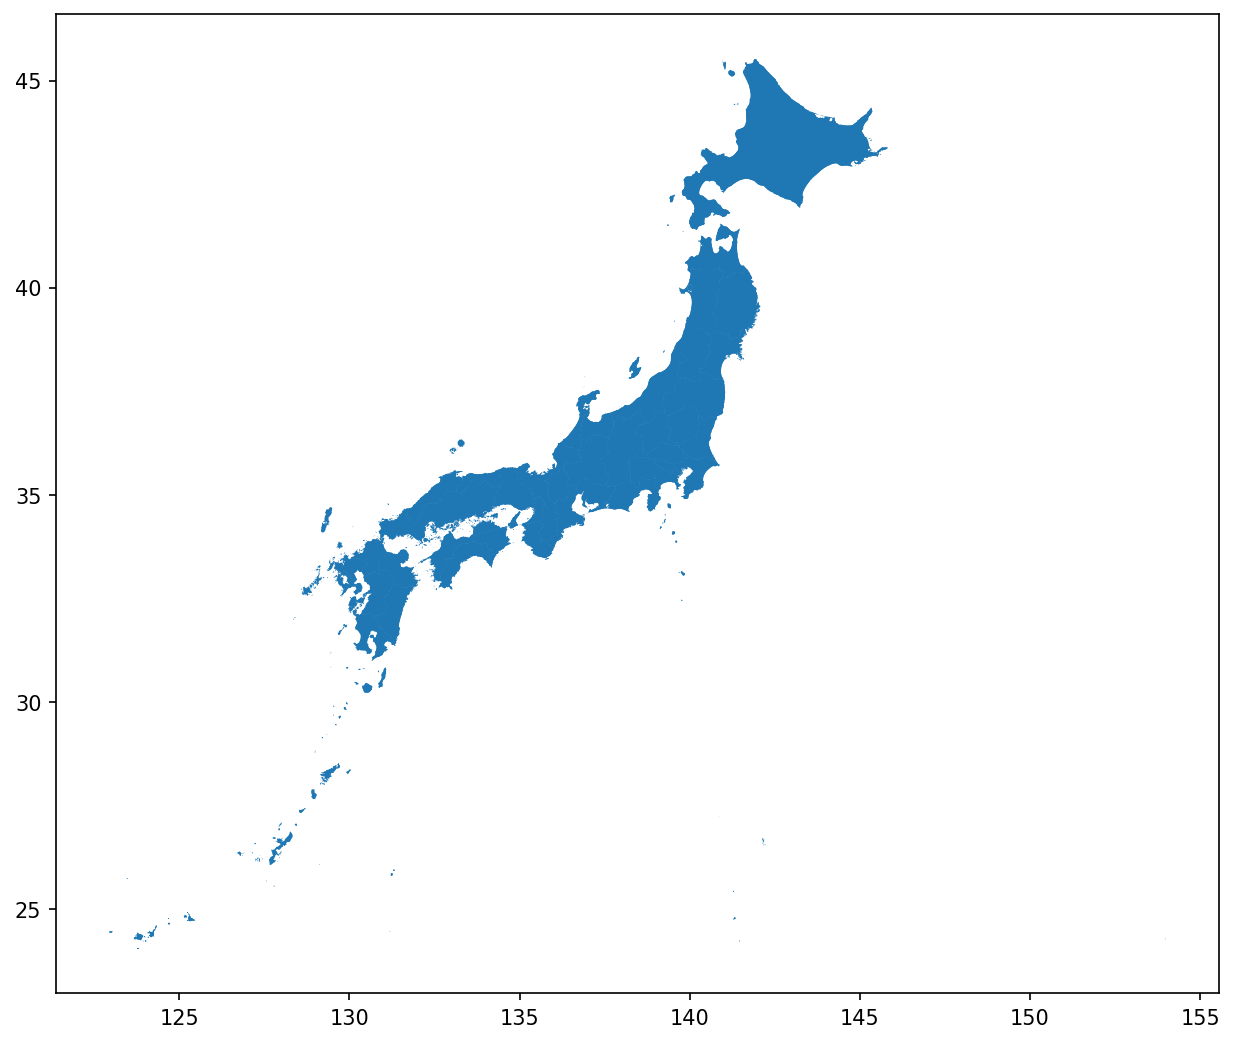

In [22]:
ax = jpnShp.plot(figsize=(10, 10))
jpnShp.plot(ax=ax)
plt.show();

今回は都道府県レベルのデータを利用していますので、境界も描画します。加えて、名前も重畳します。

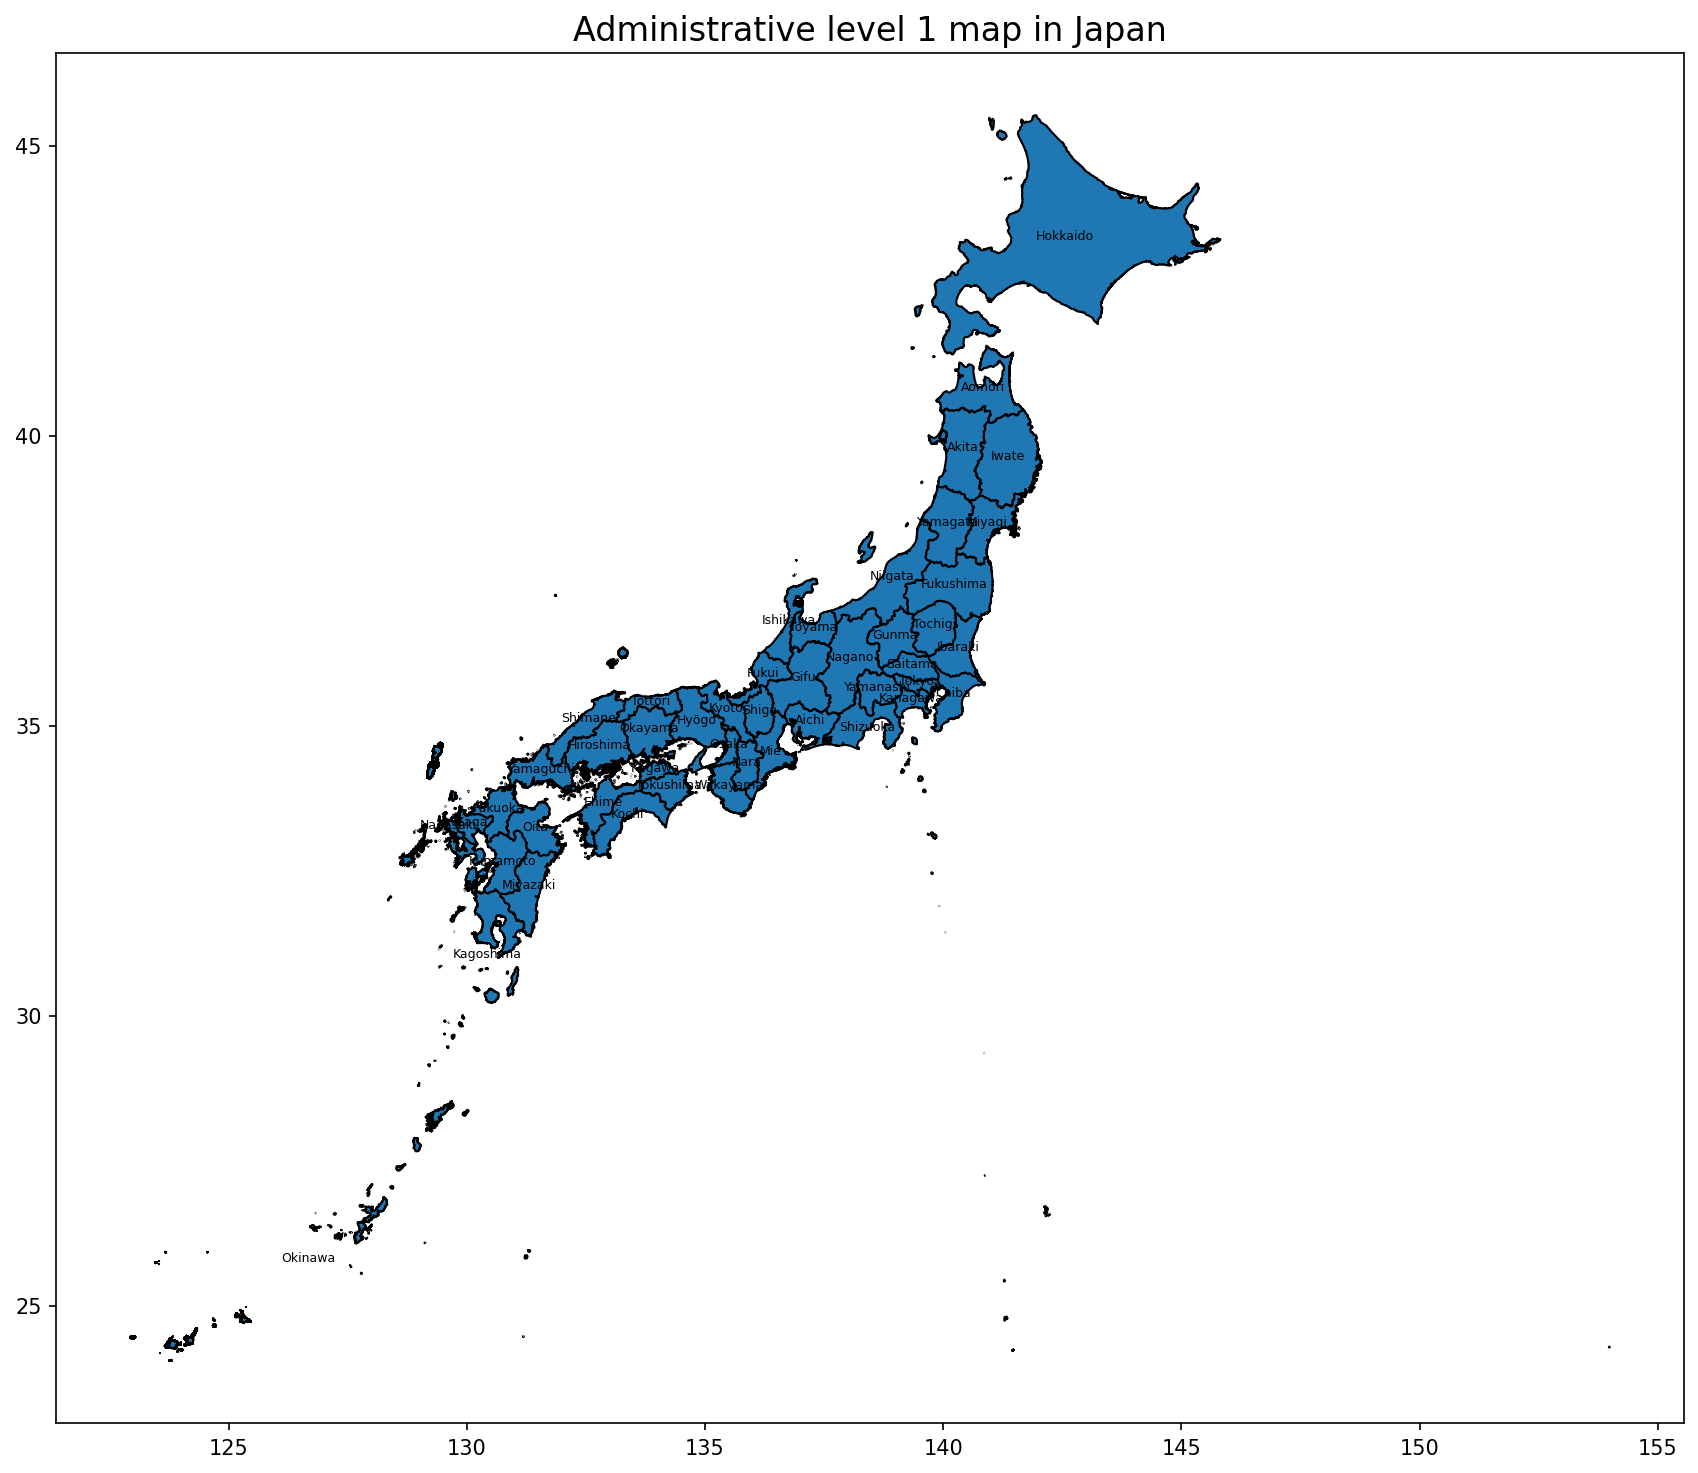

In [30]:
# 日本のシェープデータを可視化する
ax = jpnShp.plot(figsize=(14, 14))
# 日本の都道府県を地図上に重畳する
jpnShp.apply(lambda x: ax.annotate(text=x.NAME_1, xy=x.geometry.centroid.coords[0], ha='center', color = 'black', size = 6),axis=1)
# 行政区画を描画（都道府県レベル）
jpnShp.plot(ax = ax, edgecolors='black')
# プロットタイトル
plt.title('Administrative level 1 map in Japan', fontsize=16)
# 地図の描画
plt.show();

GeoDataFramedではShapelyとmatplotlibにより、簡単にベクターデータを可視化することができます。それでは、この図と先ほど取得したe-statのデータを結合し、さらに描画を行います。

### shpとcsvの結合

In [31]:
# 不要な列の削除
japan = jpnShp.loc[:,['NAME_1','NL_NAME_1','geometry']].copy()

In [32]:
combDf = japan.merge(marriageDf,left_on='NL_NAME_1',right_on='prefecture',how='left') # データの結合
combDf.head() # check

NAME_1 NL_NAME_1                                           geometry   sex  \
0  Aichi       愛知県  MULTIPOLYGON (((137.00780 34.65997, 137.00803 ...  male   
1  Aichi       愛知県  MULTIPOLYGON (((137.00780 34.65997, 137.00803 ...  male   
2  Aichi       愛知県  MULTIPOLYGON (((137.00780 34.65997, 137.00803 ...  male   
3  Aichi       愛知県  MULTIPOLYGON (((137.00780 34.65997, 137.00803 ...  male   
4  Aichi       愛知県  MULTIPOLYGON (((137.00780 34.65997, 137.00803 ...  male   

  prefecture  year  avgAge  
0        愛知県  2019    31.0  
1        愛知県  2018    30.9  
2        愛知県  2017    30.9  
3        愛知県  2016    30.9  
4        愛知県  2015    30.9

再度、描画を行います。今度は、2019年の平均初婚年齢を日本地図に重畳します。

In [33]:
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [34]:
# Yamaguchi
points = gpd.GeoSeries([Point(131.5213, 34.2797), Point(132.5213, 34.2797)], crs=4326)  # Geographic WGS 84 - degrees
points = points.to_crs(6671) # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])
print(distance_meters)

92072.31426248426


In [35]:
points = gpd.GeoSeries([Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326)  # Geographic WGS 84 - degrees
points = points.to_crs(32619) # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])
print(distance_meters)

84921.4496901889


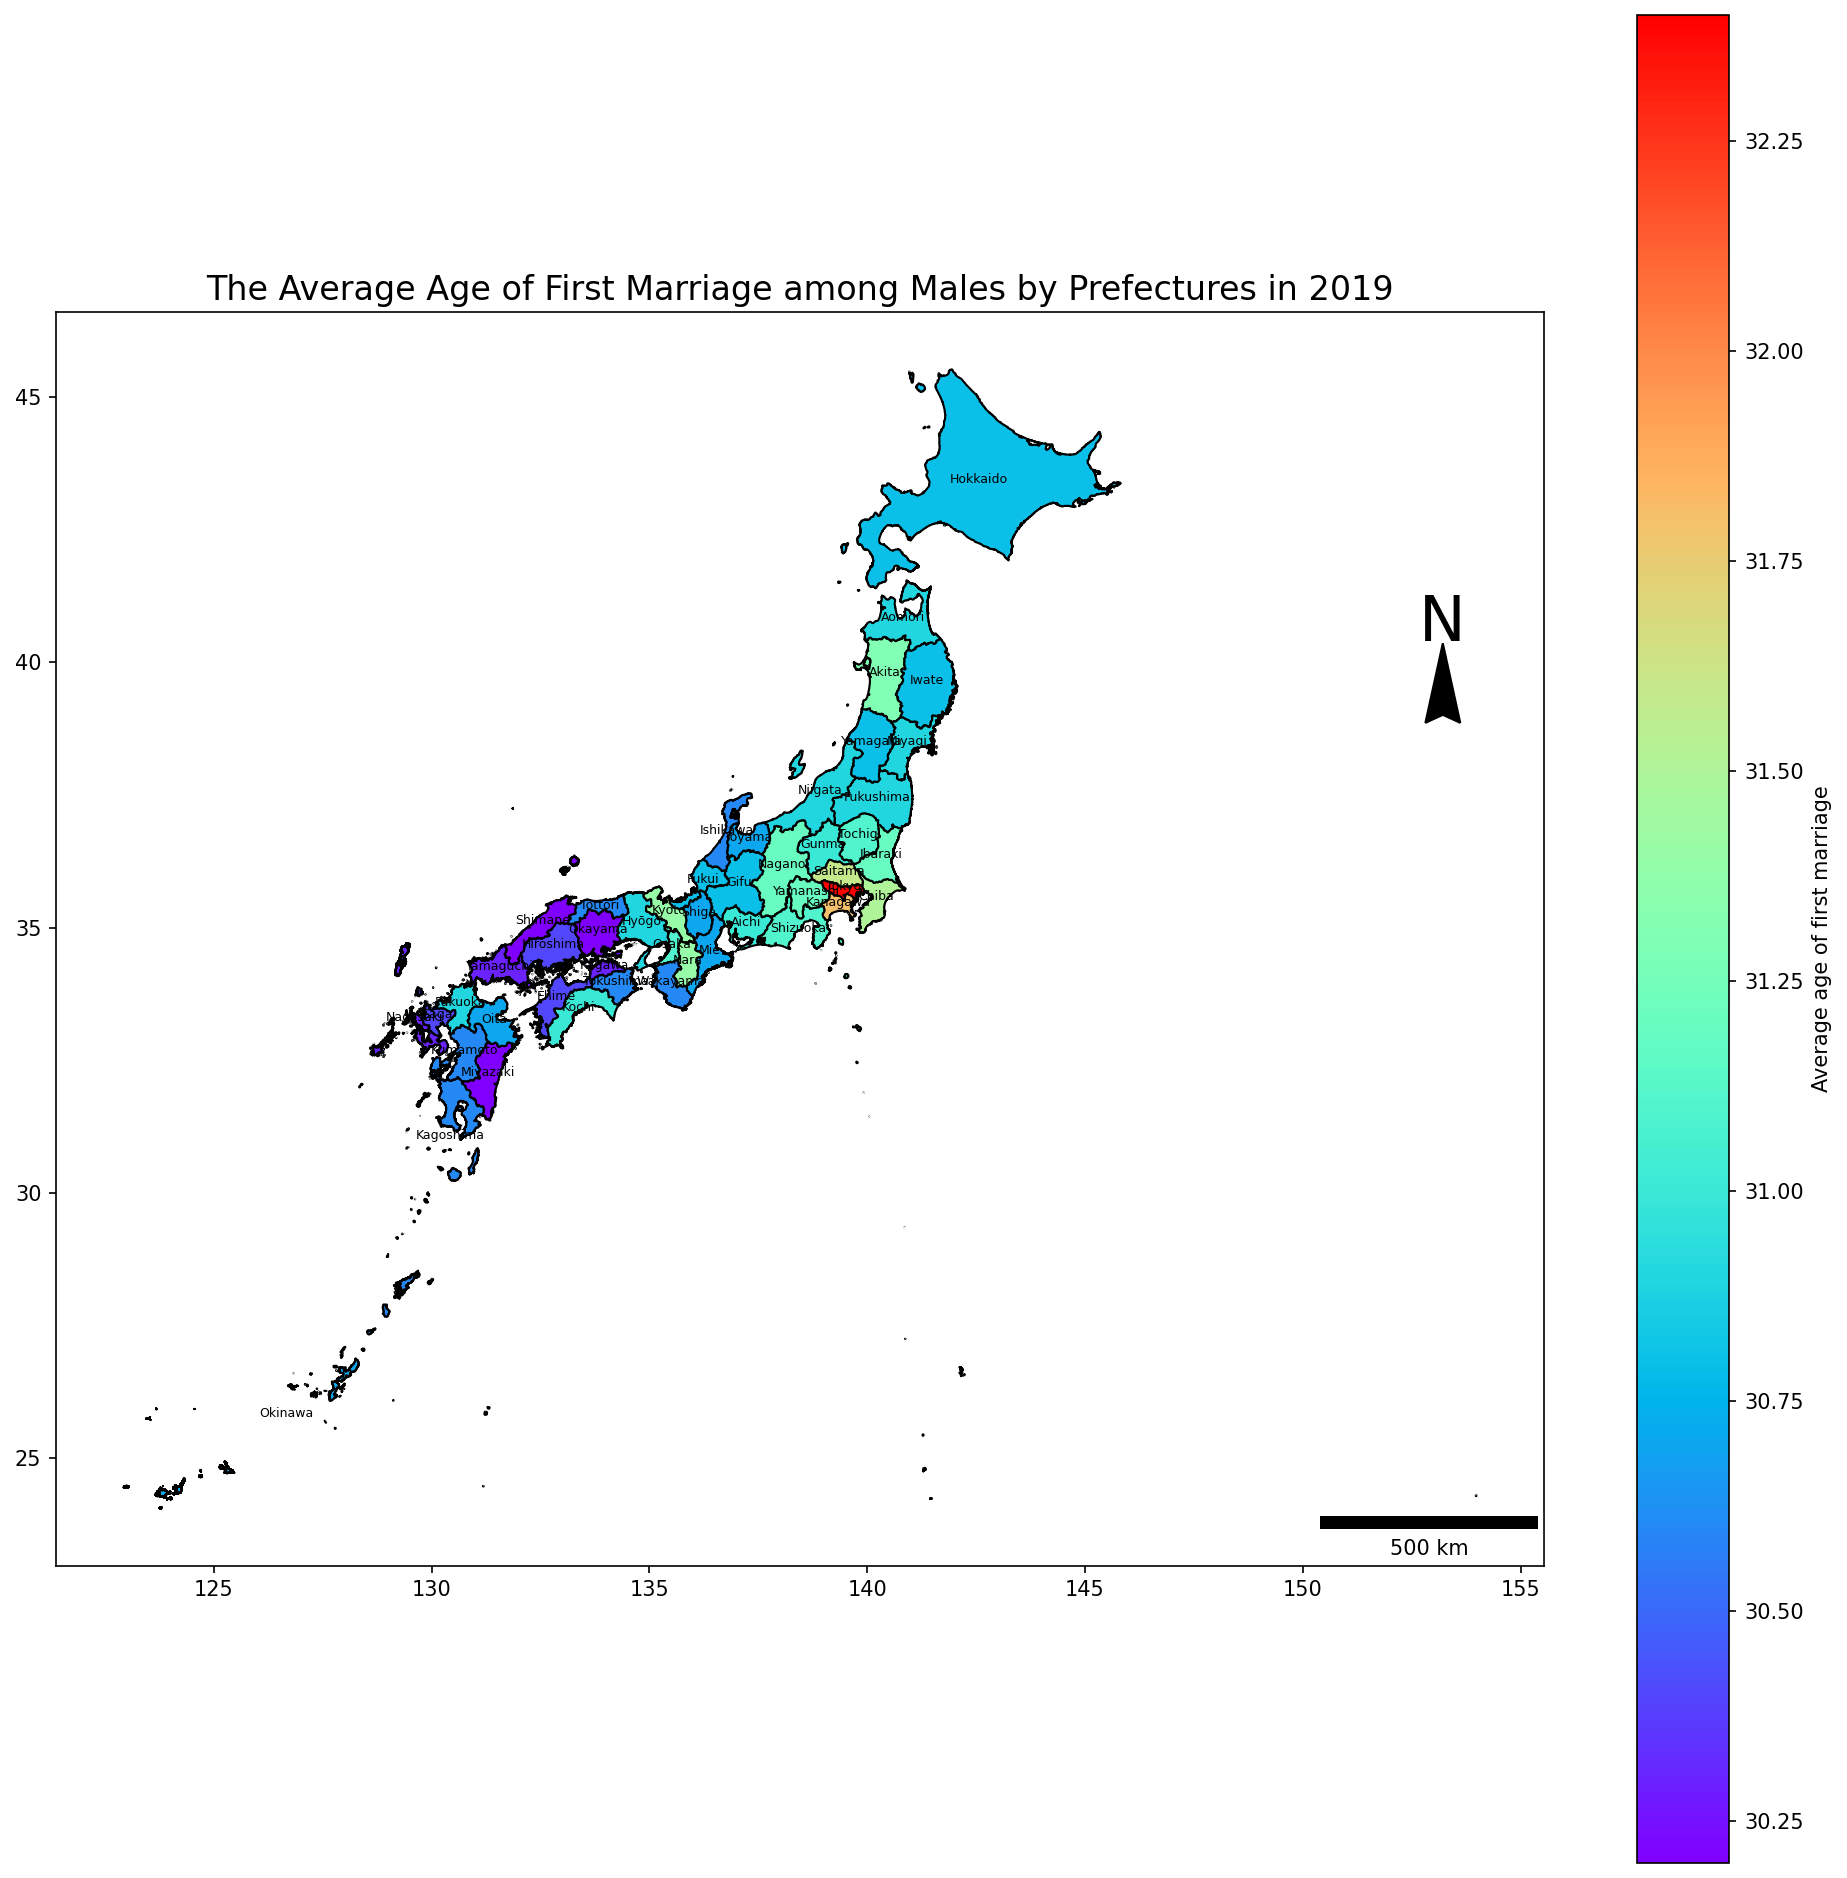

CPU times: user 2.29 s, sys: 218 ms, total: 2.51 s
Wall time: 2.26 s


In [36]:
# 男性
# 方位の作成についての参考記事：
## https://mohammadimranhasan.com/geospatial-data-mapping-with-python/
combDf2019M = combDf.loc[(combDf.year == 2019)&(combDf.sex == 'male'),:].reset_index(drop=True).copy()
ax = combDf2019M.plot(figsize=(16, 16))
scalebar = ScaleBar(100, location='lower right',units='km')
# ax.add_artist(ScaleBar(distance_meters))
ax.add_artist(scalebar) # 200km
ax.text(x=153.215-0.55, y=40.4, s='N', fontsize=30) # North Arrow
ax.arrow(153.215, 39.36, 0, 1, length_includes_head=True,
          head_width=0.8, head_length=1.5, overhang=.1, facecolor='k') # North Arrow
combDf2019M.apply(lambda x: ax.annotate(text=x.NAME_1, xy=x.geometry.centroid.coords[0], ha='center', color = 'black', size = 6),axis=1)
combDf2019M.plot(column='avgAge', cmap = 'rainbow', edgecolors='black', ax = ax, legend=True,legend_kwds={'label': "Average age of first marriage",'orientation': "vertical"})
plt.title('The Average Age of First Marriage among Males by Prefectures in 2019', fontsize=16)
plt.show();

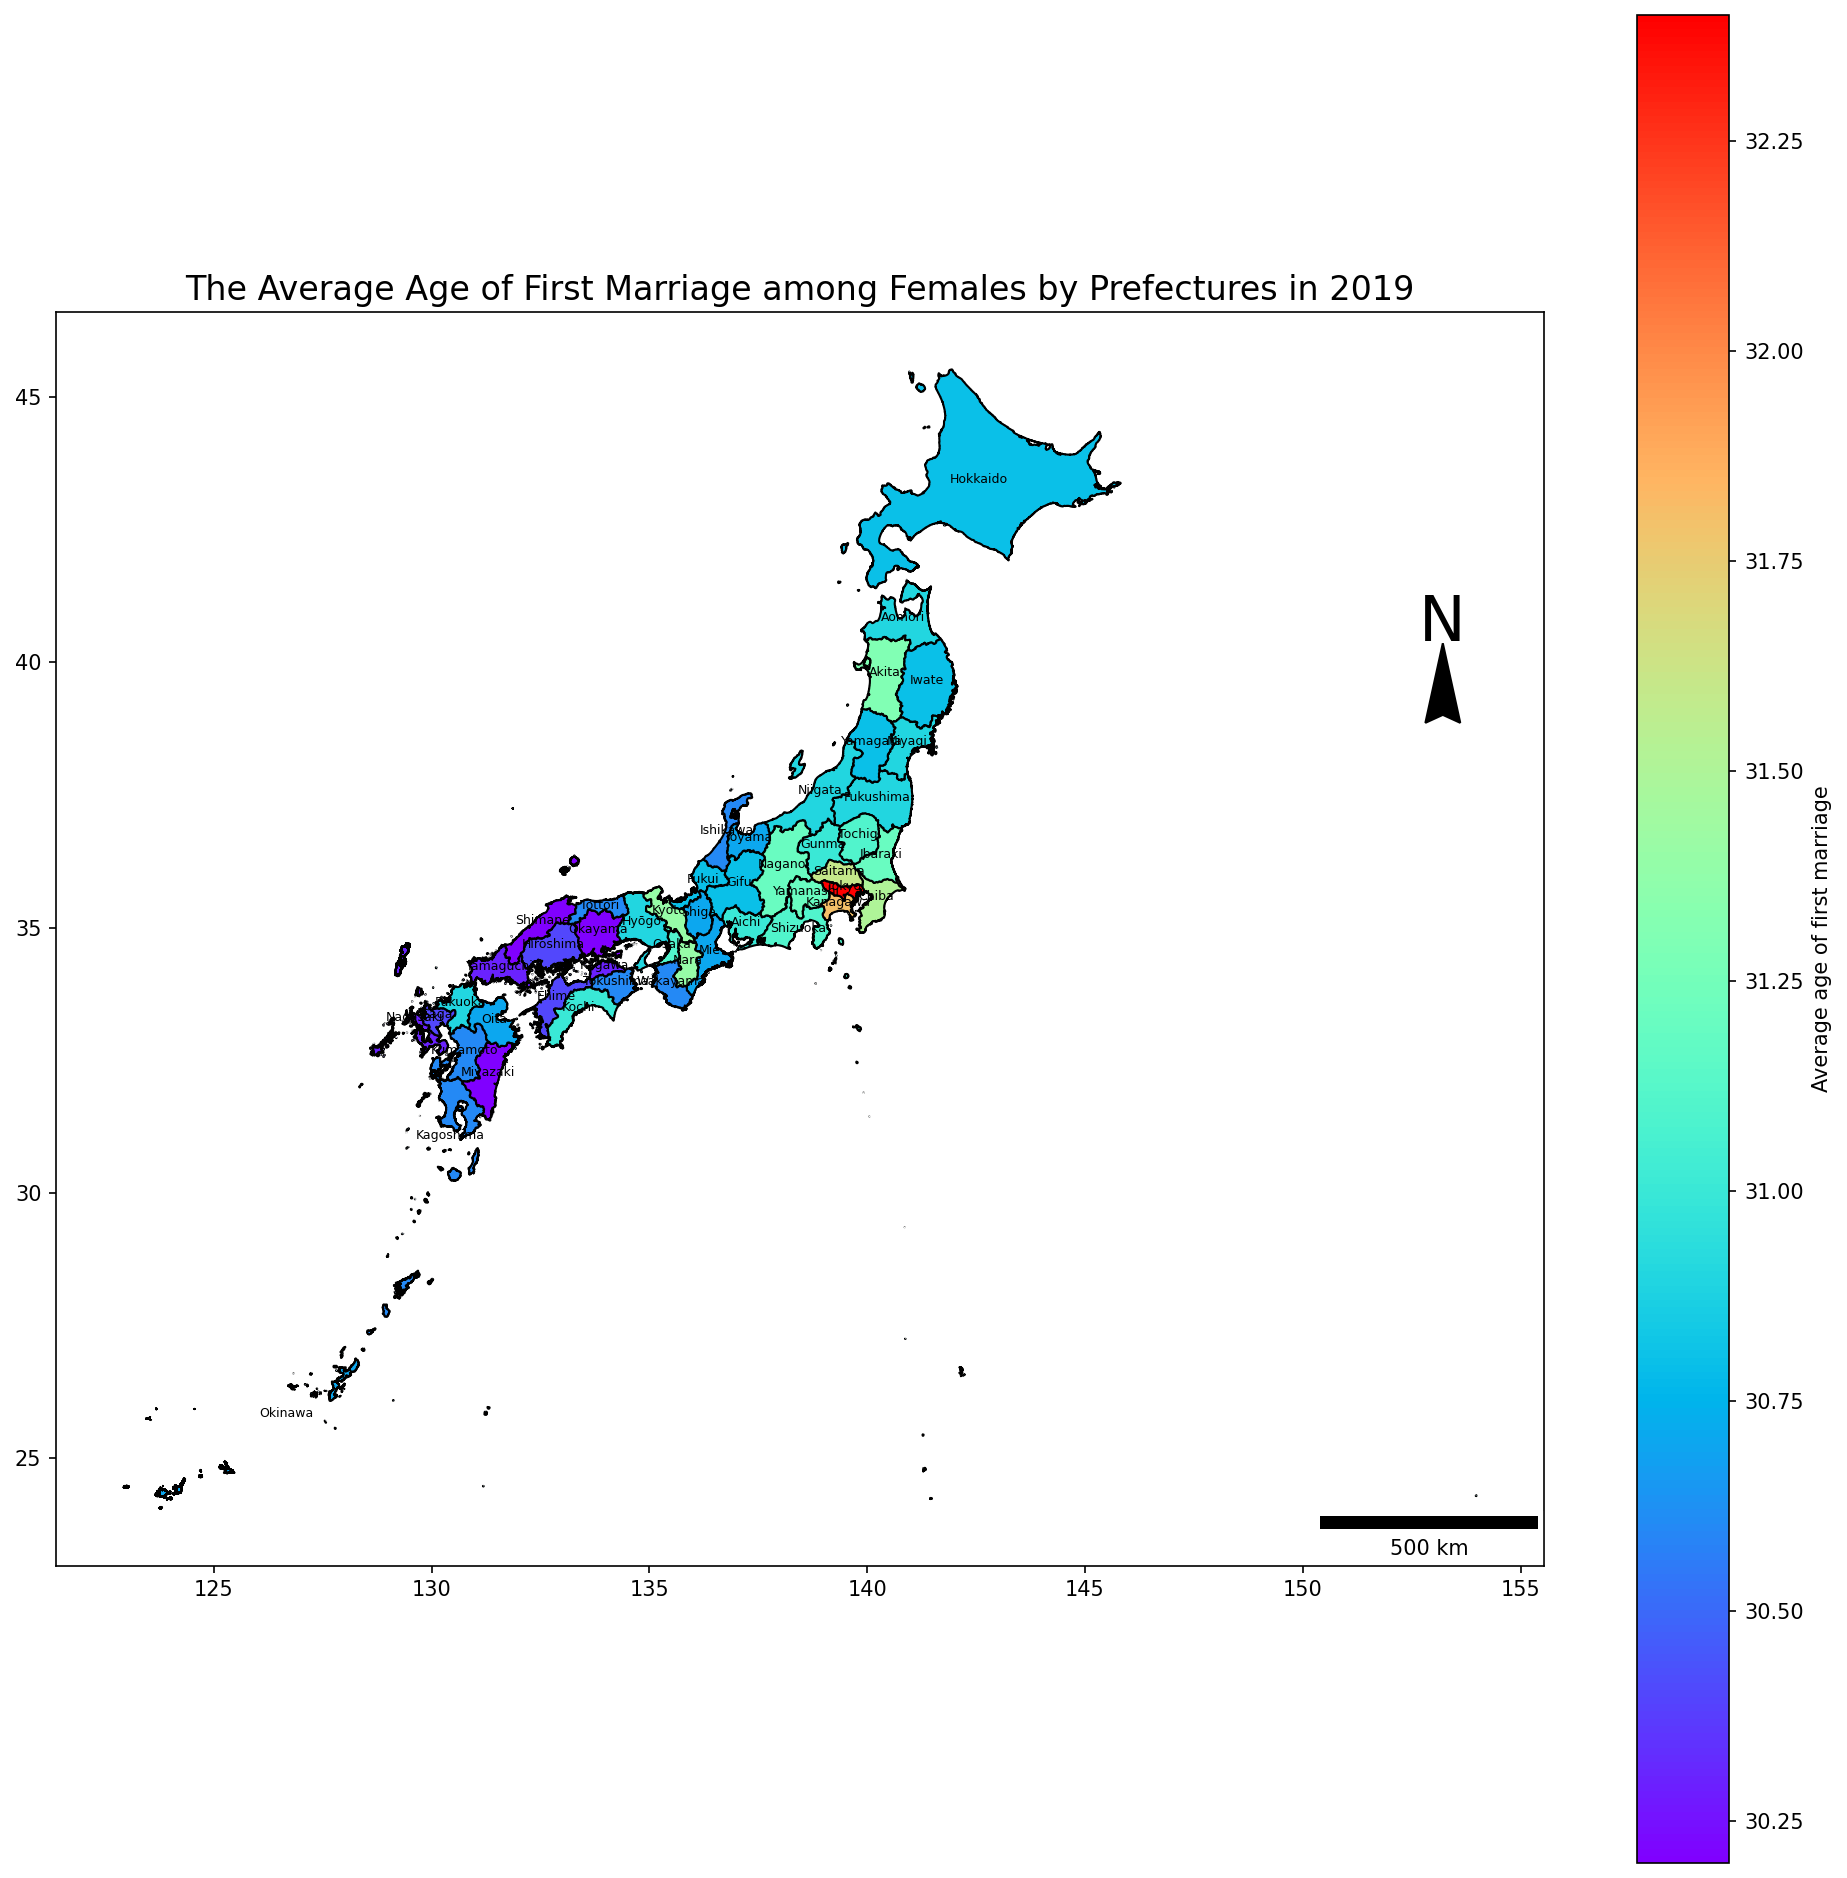

In [37]:
# 女性
combDf2019F = combDf.loc[(combDf.year == 2019)&(combDf.sex == 'female'),:].reset_index(drop=True).copy()
ax = combDf2019F.plot(figsize=(16, 16))
scalebar = ScaleBar(100, location='lower right',units='km')
ax.add_artist(scalebar) # 500km
ax.text(x=153.215-0.55, y=40.4, s='N', fontsize=30) # North Arrow
ax.arrow(153.215, 39.36, 0, 1, length_includes_head=True,
          head_width=0.8, head_length=1.5, overhang=.1, facecolor='k') # North Arrow
combDf2019F.apply(lambda x: ax.annotate(text=x.NAME_1, xy=x.geometry.centroid.coords[0], ha='center', color = 'black', size = 6),axis=1)
combDf2019M.plot(column='avgAge', cmap = 'rainbow', edgecolors='black', ax = ax, legend=True,legend_kwds={'label': "Average age of first marriage",'orientation': "vertical"})
plt.title('The Average Age of First Marriage among Females by Prefectures in 2019', fontsize=16)
plt.show();

In [38]:
# 男性のみを抽出（4年分）
combDf2018M = combDf.loc[(combDf.year == 2018)&(combDf.sex == 'male'),:].reset_index(drop=True).copy()
combDf2017M = combDf.loc[(combDf.year == 2017)&(combDf.sex == 'male'),:].reset_index(drop=True).copy()
combDf2016M = combDf.loc[(combDf.year == 2016)&(combDf.sex == 'male'),:].reset_index(drop=True).copy()
combDf2015M = combDf.loc[(combDf.year == 2015)&(combDf.sex == 'male'),:].reset_index(drop=True).copy()

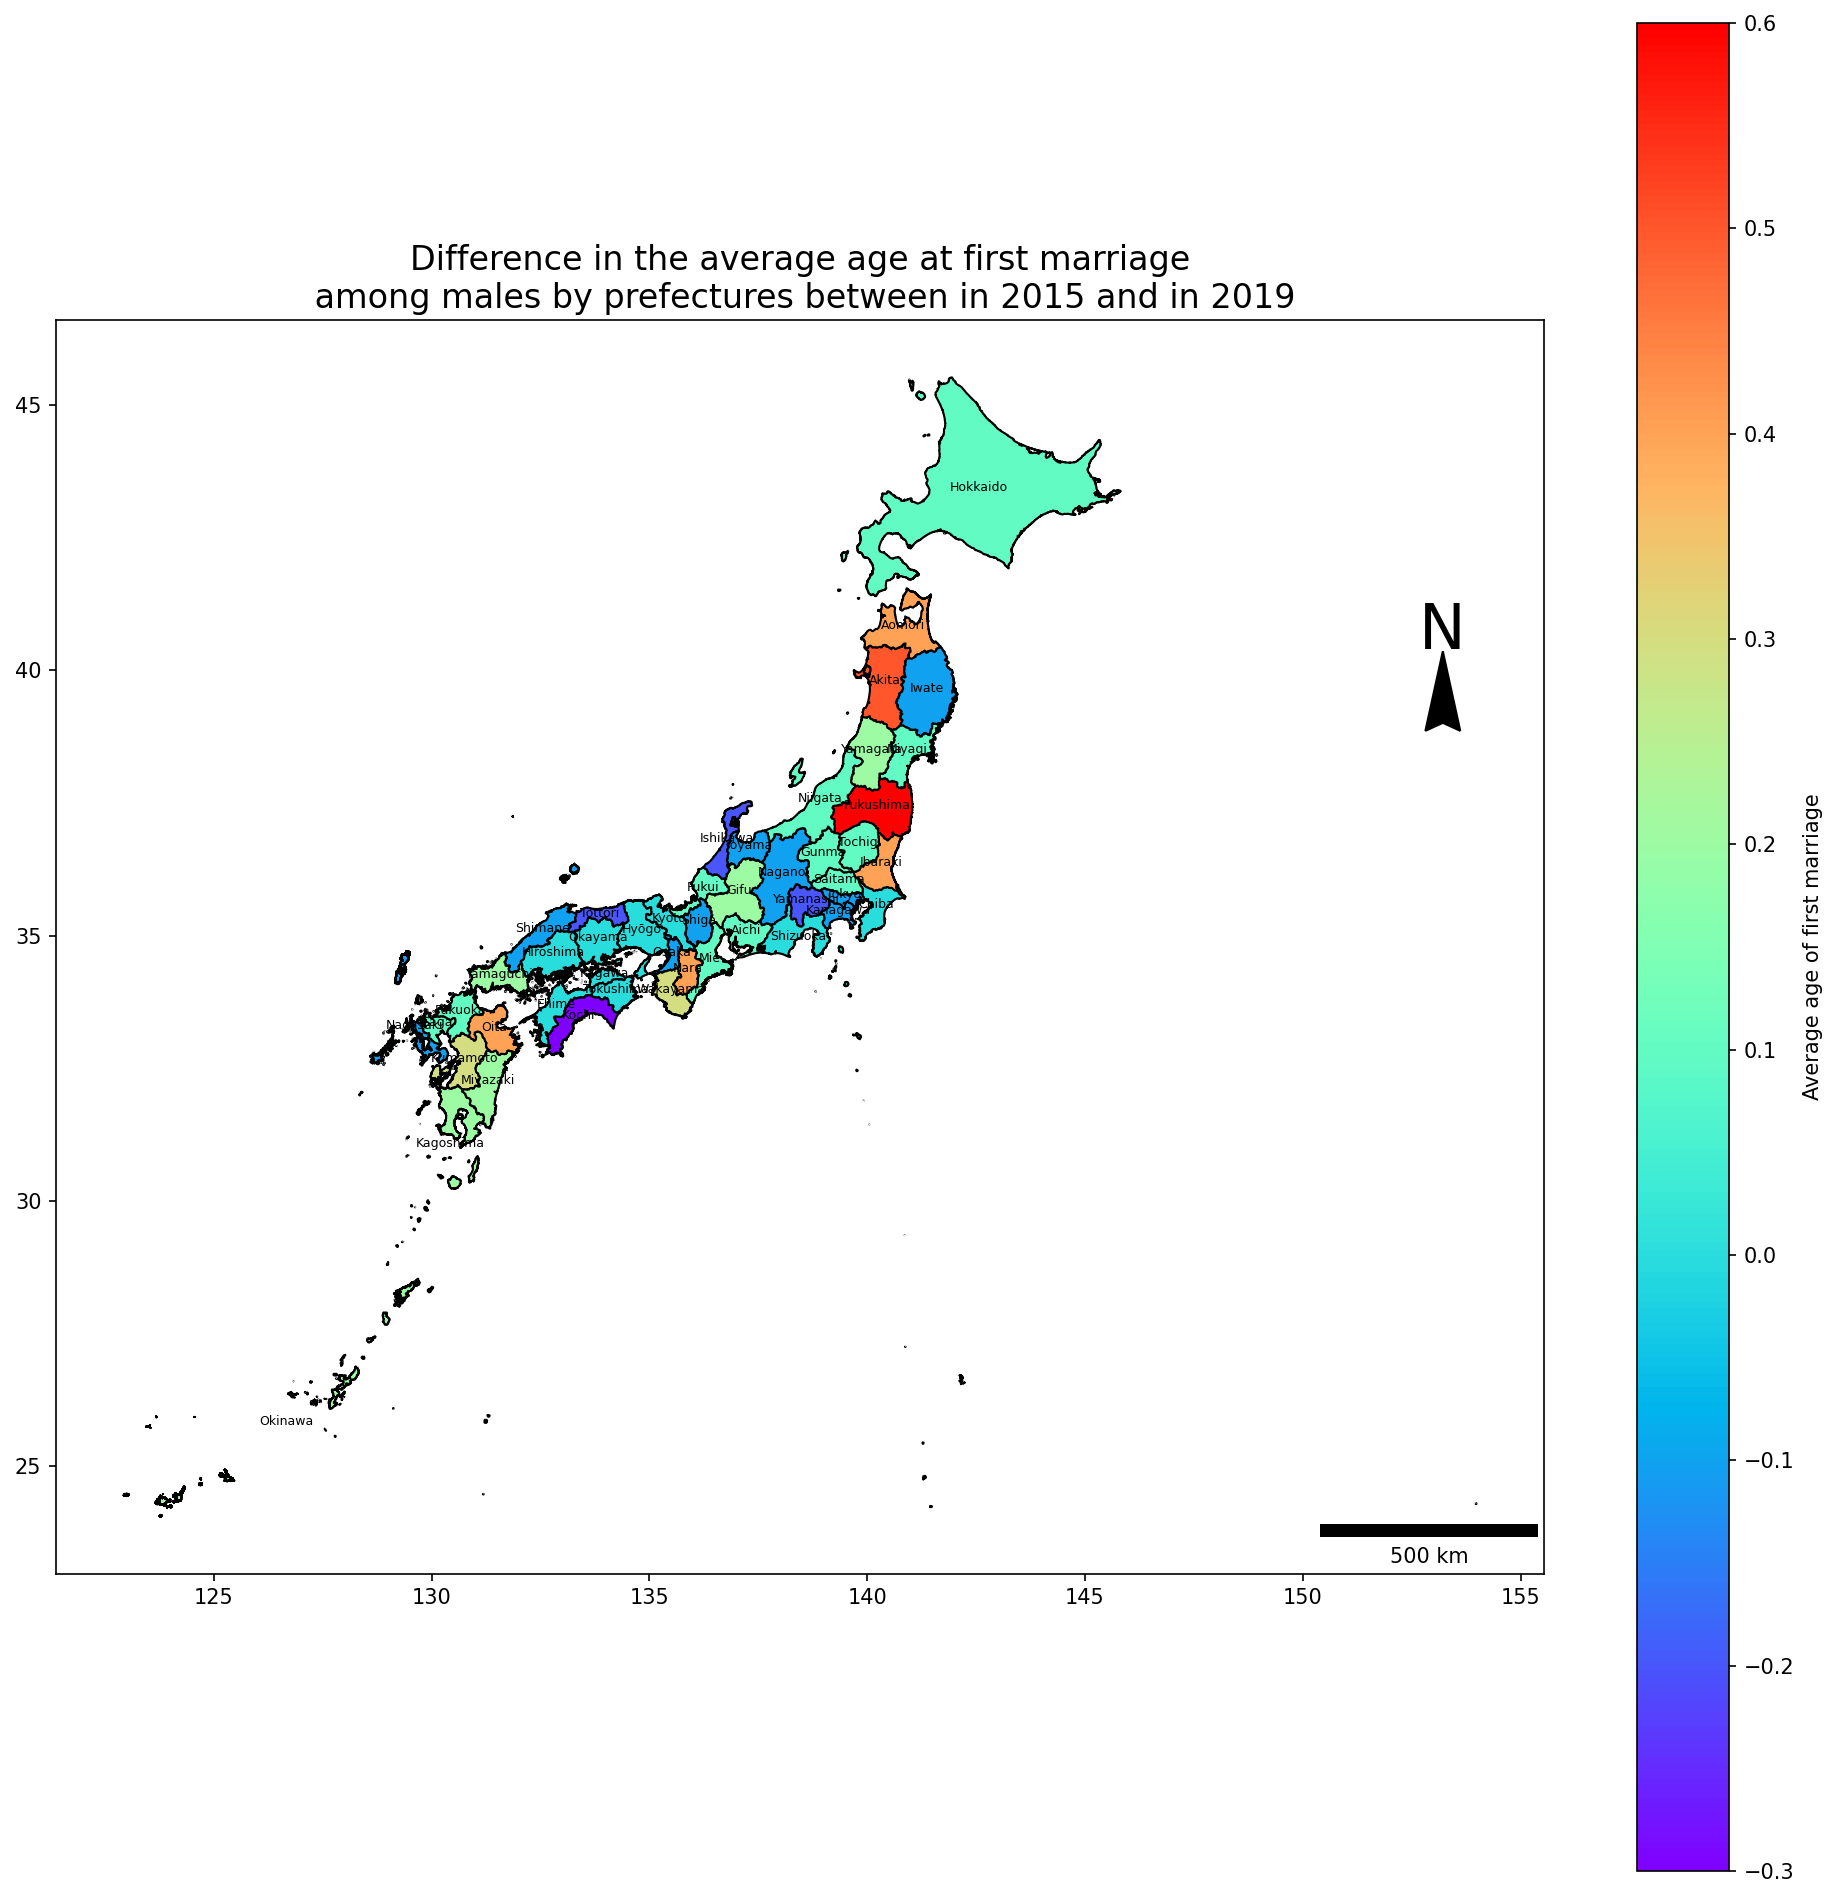

In [39]:
combDf2019M = combDf.loc[(combDf.year == 2019)&(combDf.sex == 'male'),:].reset_index(drop=True).copy()
diffAge = pd.Series(combDf2019M.avgAge - combDf2015M.avgAge, dtype='float', name='diffAge')
# diff20152019 = pd.concat([combDf2019M, diffAge], axis=1)
combDf2019M['diffAge'] = diffAge
# 男性
# 方位の作成についての参考記事：
## https://mohammadimranhasan.com/geospatial-data-mapping-with-python/
ax = combDf2019M.plot(figsize=(16, 16))
scalebar = ScaleBar(100, location='lower right',units='km')
ax.add_artist(scalebar) # 500km
ax.text(x=153.215-0.55, y=40.4, s='N', fontsize=30) # North Arrow
ax.arrow(153.215, 39.36, 0, 1, length_includes_head=True,
          head_width=0.8, head_length=1.5, overhang=.1, facecolor='k') # North Arrow
combDf2019M.apply(lambda x: ax.annotate(text=x.NAME_1, xy=x.geometry.centroid.coords[0], ha='center', color = 'black', size = 6),axis=1)
combDf2019M.plot(column='diffAge', cmap = 'rainbow', edgecolors='black', ax = ax, legend=True,legend_kwds={'label': "Average age of first marriage",'orientation': "vertical"})
plt.title('Difference in the average age at first marriage\n among males by prefectures between in 2015 and in 2019', fontsize=16)
plt.show();

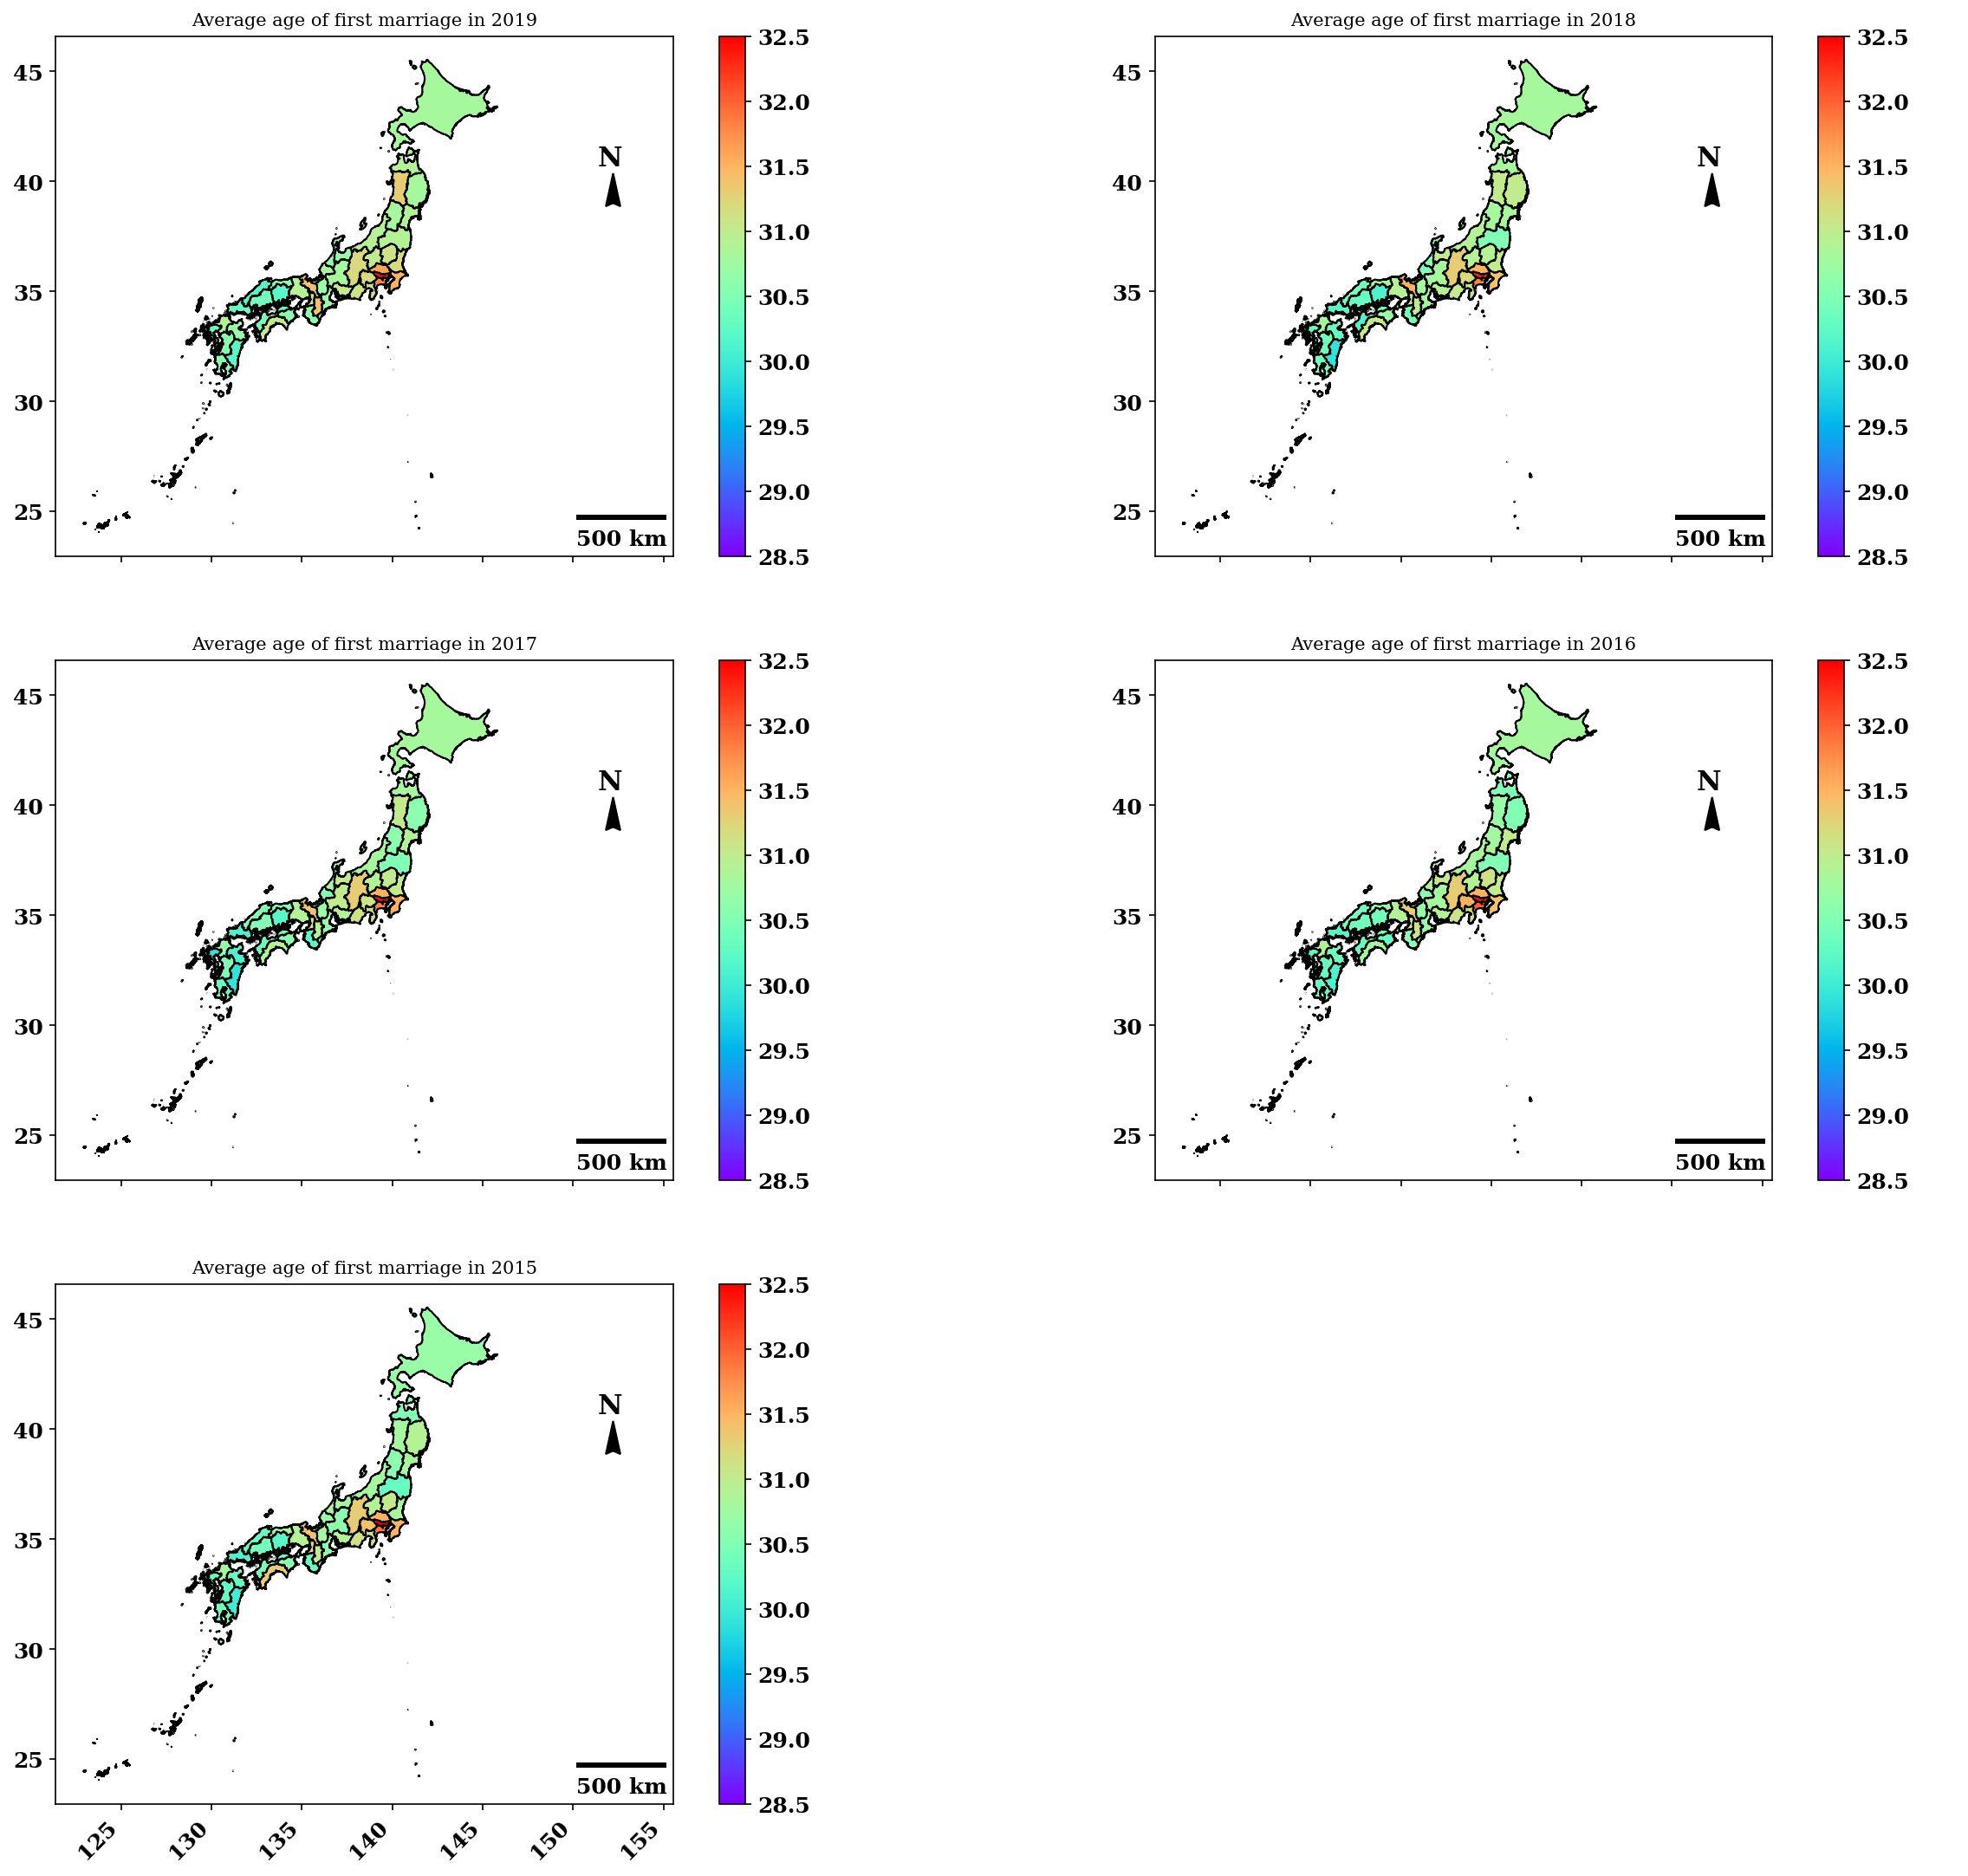

In [40]:
with plt.rc_context(rc={'font.family': 'serif', 'font.weight': 'bold', 'font.size': 12}):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize = (20,20))
    fig.autofmt_xdate(rotation = 45)
    # 2019
    scalebar = ScaleBar(100, location='lower right',units='km')
    combDf2019M.plot(column='avgAge', cmap = 'rainbow', edgecolors='black', ax = ax1, legend=True,vmin=28.5, vmax=32.5)
    ax1.set_title('Average age of first marriage in 2019', fontsize=10)
    ax1.text(x=152.215-0.85, y=40.7, s='N', fontsize=15) # North Arrow
    ax1.arrow(152.215, 39.36, 0, 1, length_includes_head=True, head_width=0.8, head_length=1.5, overhang=.1, facecolor='k') # North Arrow
    ax1.add_artist(scalebar)
    # 2018
    scalebar = ScaleBar(100, location='lower right',units='km')
    combDf2018M.plot(column='avgAge', cmap = 'rainbow', edgecolors='black', ax = ax2, legend=True,vmin=28.5, vmax=32.5)
    ax2.set_title('Average age of first marriage in 2018', fontsize=10)
    ax2.text(x=152.215-0.85, y=40.7, s='N', fontsize=15) # North Arrow
    ax2.arrow(152.215, 39.36, 0, 1, length_includes_head=True, head_width=0.8, head_length=1.5, overhang=.1, facecolor='k') # North Arrow
    ax2.add_artist(scalebar)
    # 2017
    scalebar = ScaleBar(100, location='lower right',units='km')
    combDf2017M.plot(column='avgAge', cmap = 'rainbow', edgecolors='black', ax = ax3, legend=True, vmin=28.5, vmax=32.5)
    ax3.set_title('Average age of first marriage in 2017', fontsize=10)
    ax3.text(x=152.215-0.85, y=40.7, s='N', fontsize=15) # North Arrow
    ax3.arrow(152.215, 39.36, 0, 1, length_includes_head=True, head_width=0.8, head_length=1.5, overhang=.1, facecolor='k') # North Arrow
    ax3.add_artist(scalebar)
    # 2016
    scalebar = ScaleBar(100, location='lower right',units='km')
    combDf2016M.plot(column='avgAge', cmap = 'rainbow', edgecolors='black', ax = ax4, legend=True, vmin=28.5, vmax=32.5)
    ax4.set_title('Average age of first marriage in 2016', fontsize=10)
    ax4.text(x=152.215-0.85, y=40.7, s='N', fontsize=15) # North Arrow
    ax4.arrow(152.215, 39.36, 0, 1, length_includes_head=True, head_width=0.8, head_length=1.5, overhang=.1, facecolor='k') # North Arrow
    ax4.add_artist(scalebar)
    # 2015
    scalebar = ScaleBar(100, location='lower right',units='km')
    combDf2015M.plot(column='avgAge', cmap = 'rainbow', edgecolors='black', ax = ax5, legend=True, vmin=28.5, vmax=32.5)
    ax5.set_title('Average age of first marriage in 2015', fontsize=10)
    ax5.text(x=152.215-0.85, y=40.7, s='N', fontsize=15) # North Arrow
    ax5.arrow(152.215, 39.36, 0, 1, length_includes_head=True, head_width=0.8, head_length=1.5, overhang=.1, facecolor='k') # North Arrow
    ax5.add_artist(scalebar)
    # Blank
    ax6.axis('off')
    # plt.tight_layout(pad=4)
    plt.show();

年ごとに僅かな変化は見られます。基本的に関東地域で平均初婚年齢が高く、中国、九州地方で低いという傾向が見て取れます。

## 衛星データとの組み合わせ（ラスターデータとの組み合わせ）

ここから、

- 座標系
- ベクターデータをある範囲内で切り取る
- eeを用いた衛星データ(MOD13Q1)の読み込み
- 任意の切り取り範囲でデータを可視化する

について説明を行います。

### 座標系

ラスターデータやベクターデータが地理空間情報を含むということは、そのデータを地球上のどこかに当てはめることができるということです。そのため、これらのデータは、当てはめの基準を持っています。この基準を参照系と呼び、データは参照系に基にして、平面や球面状に表現されることになります。つまり、持っているデータが同じ日本を示していても、参照系が異なれば、異なったルールで描画されるということになります。そのため、参照系を共通のものにすることが重要になります。

先程作成したgeojsondデータを読み込み、その参照系を確認しましょう。

*正しくは、Coordinate Reference System (CRS：座標参照系と呼びます)


日本では19の平面直角座標系を設定し、狭い範囲での歪みを少なくするという方法をとっています。逆に言えば、その他の地域では歪みを許容しているということになります。

WGS 84とサンソン図法（正弦曲線図法）、そして日本の平面直角座標を比べて、歪みがどのようなものかを確かめてみましょう。

WGS 84は位置情報として用いられるもので、地球面上の対象の位置を緯度と経度で示したものです。サンソン図法では角度に歪みが出ますが、面積を正しく表現できる図法です。今回使用しているものはWorld Sinusoidalで、世界地図の描画に使われているものとなります。

以下リンク先も参考にしてください。
- [地理座標系（投影法）のまとめと，緯度経度格子面積マップ作成](https://qiita.com/HidKamiya/items/e67423a8254841ce6d46)
- [座標系と測地系](https://www.cadjapan.com/topics/cim/useful/words/171017_02.html)

In [43]:
# 再度日本のポリゴンを読み込み
# データはGADMから(https://geodata.ucdavis.edu/gadm/gadm4.1/gpkg/gadm41_JPN.gpkg)
# パスは保管場所に合わせて変更
jpn_poly_path = "/content/drive/MyDrive/Colab Notebooks/書籍notebooks/data/gadm41_JPN.gpkg"
jpnShp = gpd.read_file(jpn_poly_path)
jpnShp.crs # 初期値はWGS 84の地理座標形

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

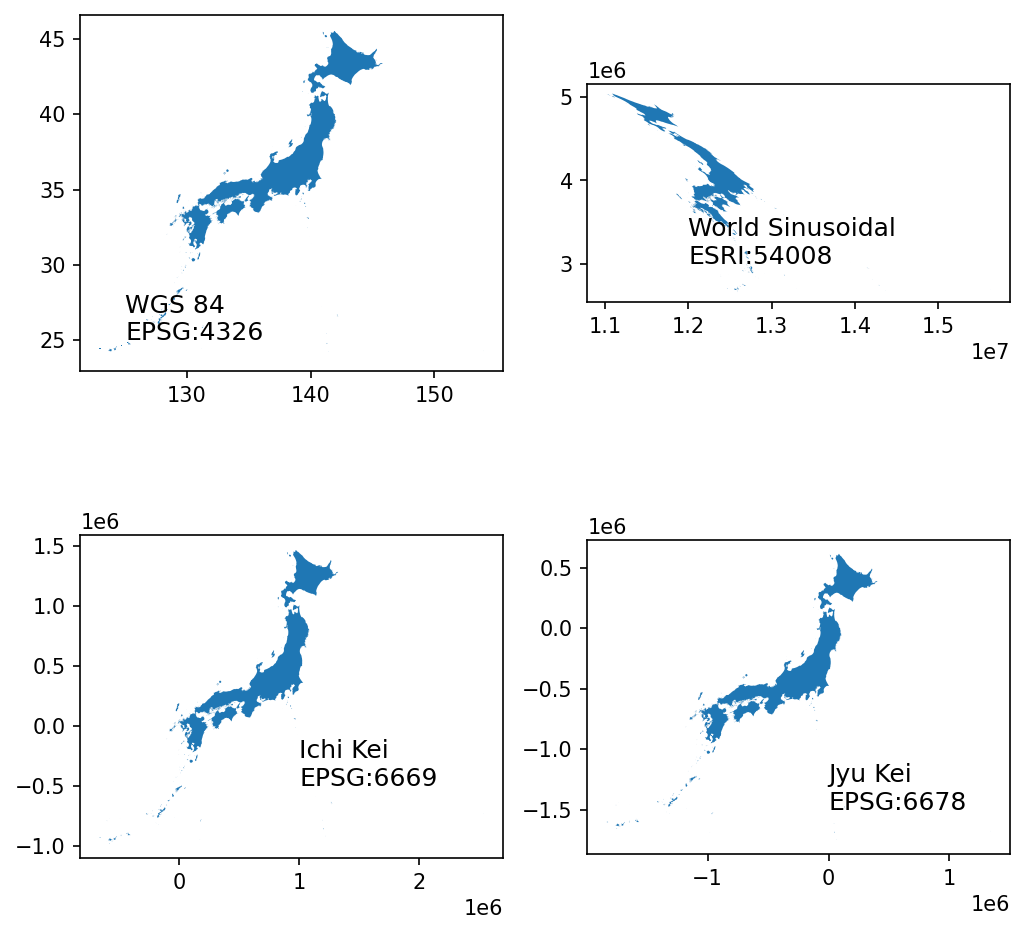

In [44]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (8,8))

jpnShp.plot(ax=ax1) # WGS 84
ax1.text(x=125, y=25, s='WGS 84\nEPSG:4326', fontsize=12)

# Convert 4326 to esri:54008
# World Sinusoidal (正弦曲線（Sinusoidal）図法)
jpnShp.to_crs('esri:54008',inplace=True)
jpnShp.plot(ax=ax2) # 6678
ax2.text(x=12000000, y=3000000, s='World Sinusoidal\nESRI:54008', fontsize=12)

# Convert esri:54008 to 6669
# 長崎県、鹿児島県の一部に対応 (平面直角座標系)
jpnShp.to_crs('epsg:6669',inplace=True)
jpnShp.plot(ax=ax3) # espg 6669
ax3.text(x=1000000, y=-500000, s='Ichi Kei\nEPSG:6669', fontsize=12)

# Convert 6669 to 6678
# 青森県、秋田県、山形県、岩手県、宮城県 (平面直角座標系)
jpnShp.to_crs('epsg:6678',inplace=True)
jpnShp.plot(ax=ax4) # 6678
ax4.text(x=0, y=-1500000, s='Jyu Kei\nEPSG:6678', fontsize=12)

plt.show()

ここからは、具体的に参照系の変換を行なっていきます。

利用するデータは以下の通りです：

- [庄内エリアのgeojson](https://github.com/sorabatake/article_20455_geopandas/blob/master/input/shounai.geojson)
- [庄内エリアの筆ポリゴン](https://github.com/sorabatake/article_20455_geopandas/blob/master/input/062032019_5.geojson)

確認のため、foliumで簡単に場所を示してみます。

下のセルでは、geometryというメソッドを利用しています。GeoSeriesの属性はメソッドはほとんどがshapely由来のものです。


In [46]:
# read GeoJSON
# ファイルを保存する階層に合わせて適宜パスは変更してください
shounai_path = "/content/drive/MyDrive/Colab Notebooks/書籍notebooks/data/shounai.geojson"
shounai = gpd.read_file(shounai_path)
shounai.head()

geometry
0  POLYGON ((139.80210 38.81213, 139.79218 38.810...

In [47]:
latlon = [shounai.geometry.centroid.y[0],shounai.geometry.centroid.x[0]] # ポリゴンの中心座標を求める

m = folium.Map(latlon, zoom_start=12, control_scale=True) # 上で求めた中心座標を中心にzoomレベル12で描画
folium.GeoJson(shounai).add_to(m) # ベースマップにshounaiのポリゴンを重ねる
m

それでは取得したデータの空間参照系を確認してみましょう。

In [48]:
shounai.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

こちらのポリゴンデータではWGS 84という参照系が当てはめられています。地理座標系は、地球をそのまま立体と捉え（球体）、後者では球体である地球を平面に変換したものです。WGS 84は地理座標系にあたり、地球を球面として捉えています。

山形はUTM 54Nに当たるため、EPSG 6691を指定すれば良いことがわかります。

参考：https://tmizu23.hatenablog.com/entry/20091215/1260868350#f-e1e195d9

In [ ]:
# Convert 4326 to 6691
shounai.to_crs('epsg:6691',inplace=True)

In [50]:
# Check its crs
shounai.crs

<Projected CRS: EPSG:6691>
Name: JGD2011 / UTM zone 54N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Japan - between 138°E and 144°E, onshore and offshore.
- bounds: (138.0, 17.63, 144.0, 46.05)
Coordinate Operation:
- name: UTM zone 54N
- method: Transverse Mercator
Datum: Japanese Geodetic Datum 2011
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

WGS 84からJGD 2011座標系に置き換わっているのが分かります。投影座標系はUTM 54Nになっています。（Datumというのは測地系というものです。理想的な球面である地理座標系を構築するためのベースとなっているようなものと思ってください）。

それでは、面積(ヘクタール）を計算してみましょう。

In [51]:
shounai['area_ha'] = shounai.geometry.area/10**4
shounai.head()

geometry    area_ha
0  POLYGON ((395996.193 4296609.728, 395133.698 4...  172.35443

作成したポリゴンは、約172ヘクタールであることがわかりました。

### 二つのベクターデータの結合

山形県鶴岡市の筆ポリゴンを取得し、そのGeoJSONをGeoPandasで読み込みます。

筆ポリゴンは[こちら](https://drive.google.com/file/d/1TRT5a0IqgswVT3aq-LXLy3kurlqHHe3v/view?usp=sharing)からダウンロード可能です。

In [63]:
tsuruoka_path = "/content/drive/MyDrive/Colab Notebooks/書籍notebooks/data/tsuruoka.geojson"
fudeShounai = gpd.read_file(tsuruoka_path, encoding='cp932')
fudeShounai.head()

id  公開年度  調製年度 耕地の種類  \
0  0610-129902-083690  2021  2020     田   
1  0610-129922-083714  2021  2020     田   
2  0610-129946-083712  2021  2020     田   
3  0610-129964-083709  2021  2020     田   
4  0610-129978-083707  2021  2020     田   

                                            geometry  
0  POLYGON ((-83690.369 -129890.472, -83680.892 -...  
1  POLYGON ((-83701.519 -129900.507, -83690.854 -...  
2  POLYGON ((-83682.988 -129909.028, -83671.603 -...  
3  POLYGON ((-83679.248 -129930.925, -83670.301 -...  
4  POLYGON ((-83679.782 -129948.573, -83676.939 -...

同様にCRSを確かめます。

In [64]:
fudeShounai.crs

<Projected CRS: EPSG:6678>
Name: JGD2011 / Japan Plane Rectangular CS X
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Japan - onshore - Honshu north of 38°N approximately - Aomori-ken; Akita-ken; Yamagata-ken; Iwate-ken; Miyagi-ken.
- bounds: (139.49, 37.73, 142.14, 41.58)
Coordinate Operation:
- name: Japan Plane Rectangular CS zone X
- method: Transverse Mercator
Datum: Japanese Geodetic Datum 2011
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

耕地の種類から、畑のみを抽出します。

In [65]:
fudeShounaiF = fudeShounai.loc[fudeShounai['耕地の種類'] == '畑',:]

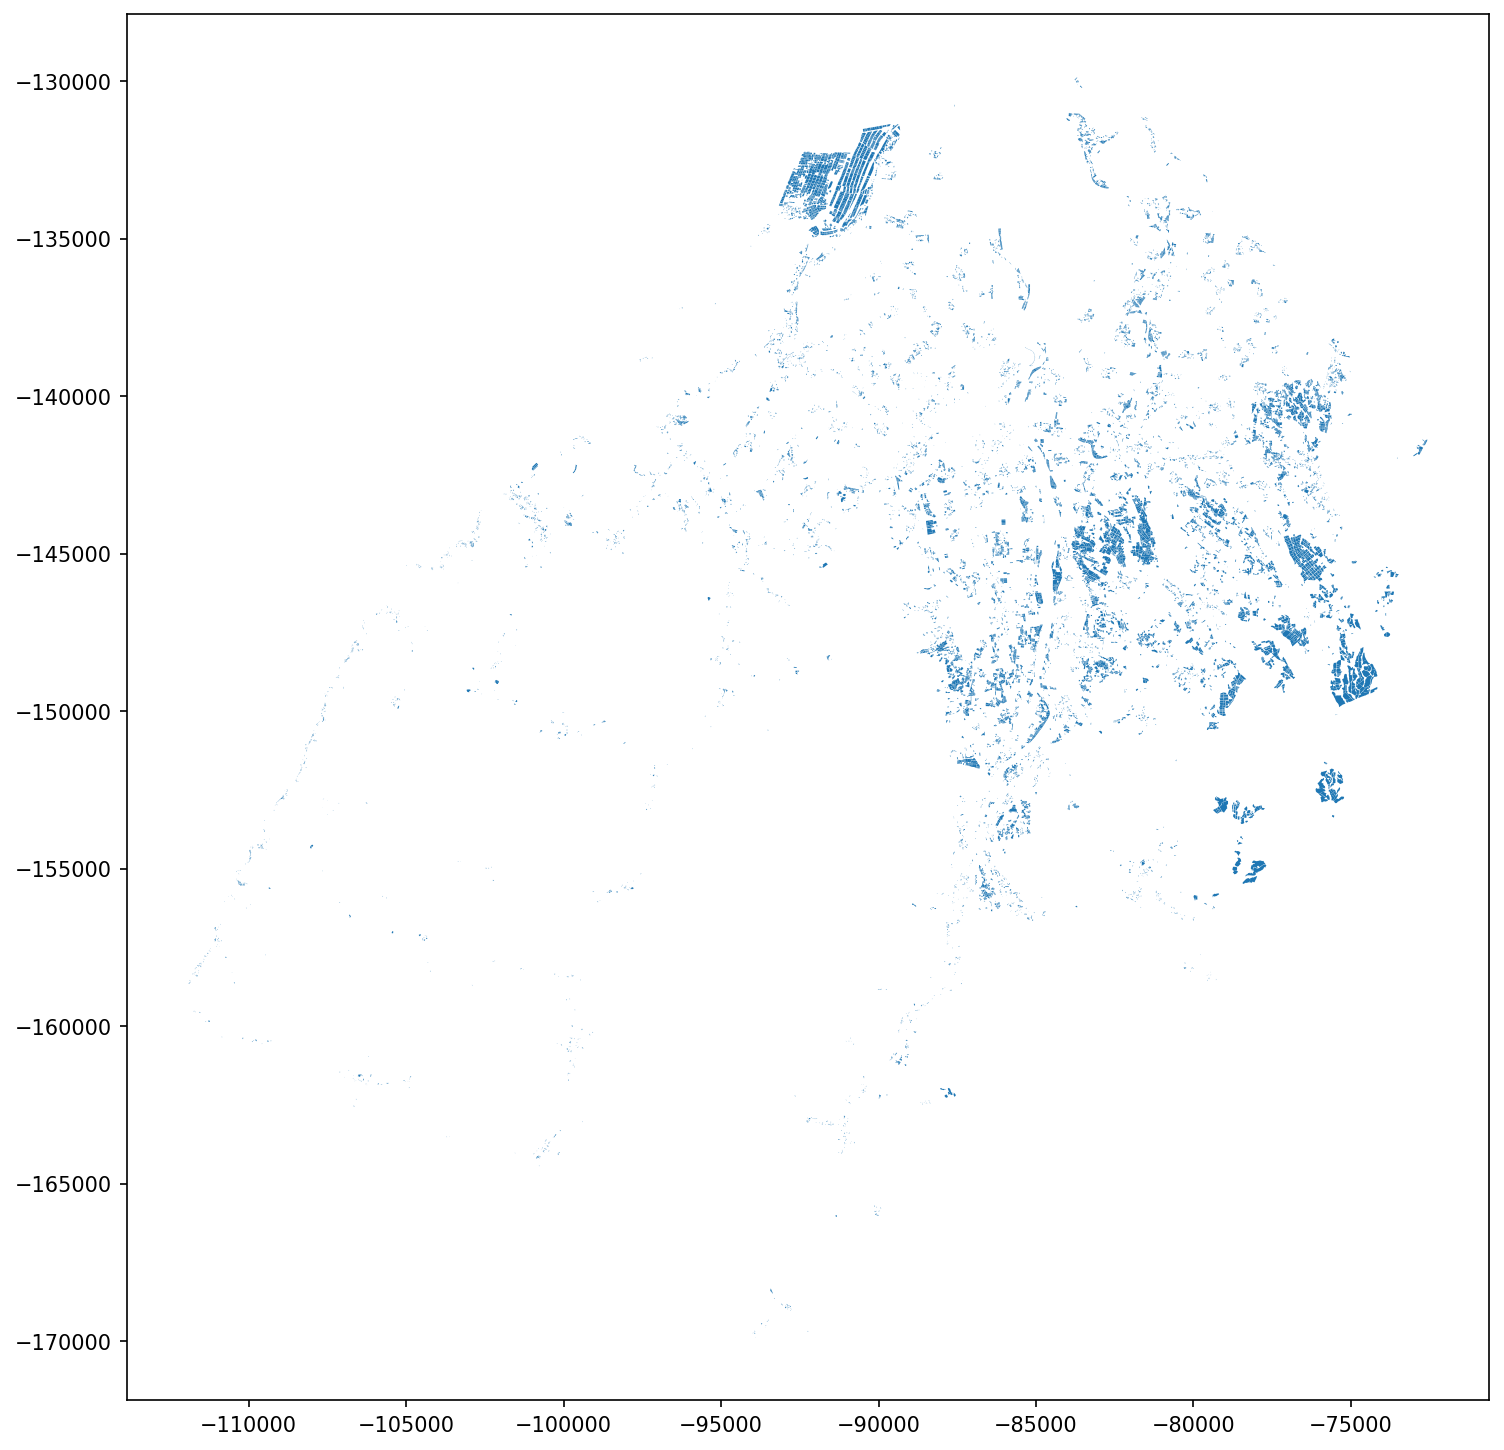

In [66]:
fudeShounaiF.plot(figsize=(12,12))
plt.show()

鶴岡市全域の畑のポリゴンが描画できました。

座標系を変換し、こちらも面積を求めてみましょう。

In [67]:
# Convert 6678 to 6691
fudeShounaiF.to_crs('epsg:6691',inplace=True)
fudeShounaiF.insert(1,'area_ha',fudeShounaiF.geometry.area/10**4) # ヘクタールへの変換

In [69]:
fudeShounaiF.head()

id   area_ha  公開年度  調製年度 耕地の種類  \
79928  0610-129901-083719  0.103960  2021  2020     畑   
79929  0610-129934-083761  0.041199  2021  2020     畑   
79930  0610-129945-083751  0.030381  2021  2020     畑   
79931  0610-129951-083744  0.039627  2021  2020     畑   
79932  0610-129984-083664  0.022018  2021  2020     畑   

                                                geometry  
79928  POLYGON ((401856.689 4298087.141, 401866.416 4...  
79929  POLYGON ((401778.636 4298019.868, 401808.188 4...  
79930  POLYGON ((401818.816 4298032.359, 401823.980 4...  
79931  POLYGON ((401823.980 4298026.762, 401831.205 4...  
79932  POLYGON ((401887.855 4297986.911, 401901.508 4...

In [70]:
# Reference about .overlay: https://atmamani.github.io/cheatsheets/open-geo/geopandas-3/
mergedGdf = gpd.overlay(shounai,fudeShounaiF,how='intersection') # 重なる部分の抽出
mergedGdf['areaIntersect'] = mergedGdf['geometry'].area/10**4

<Axes: >

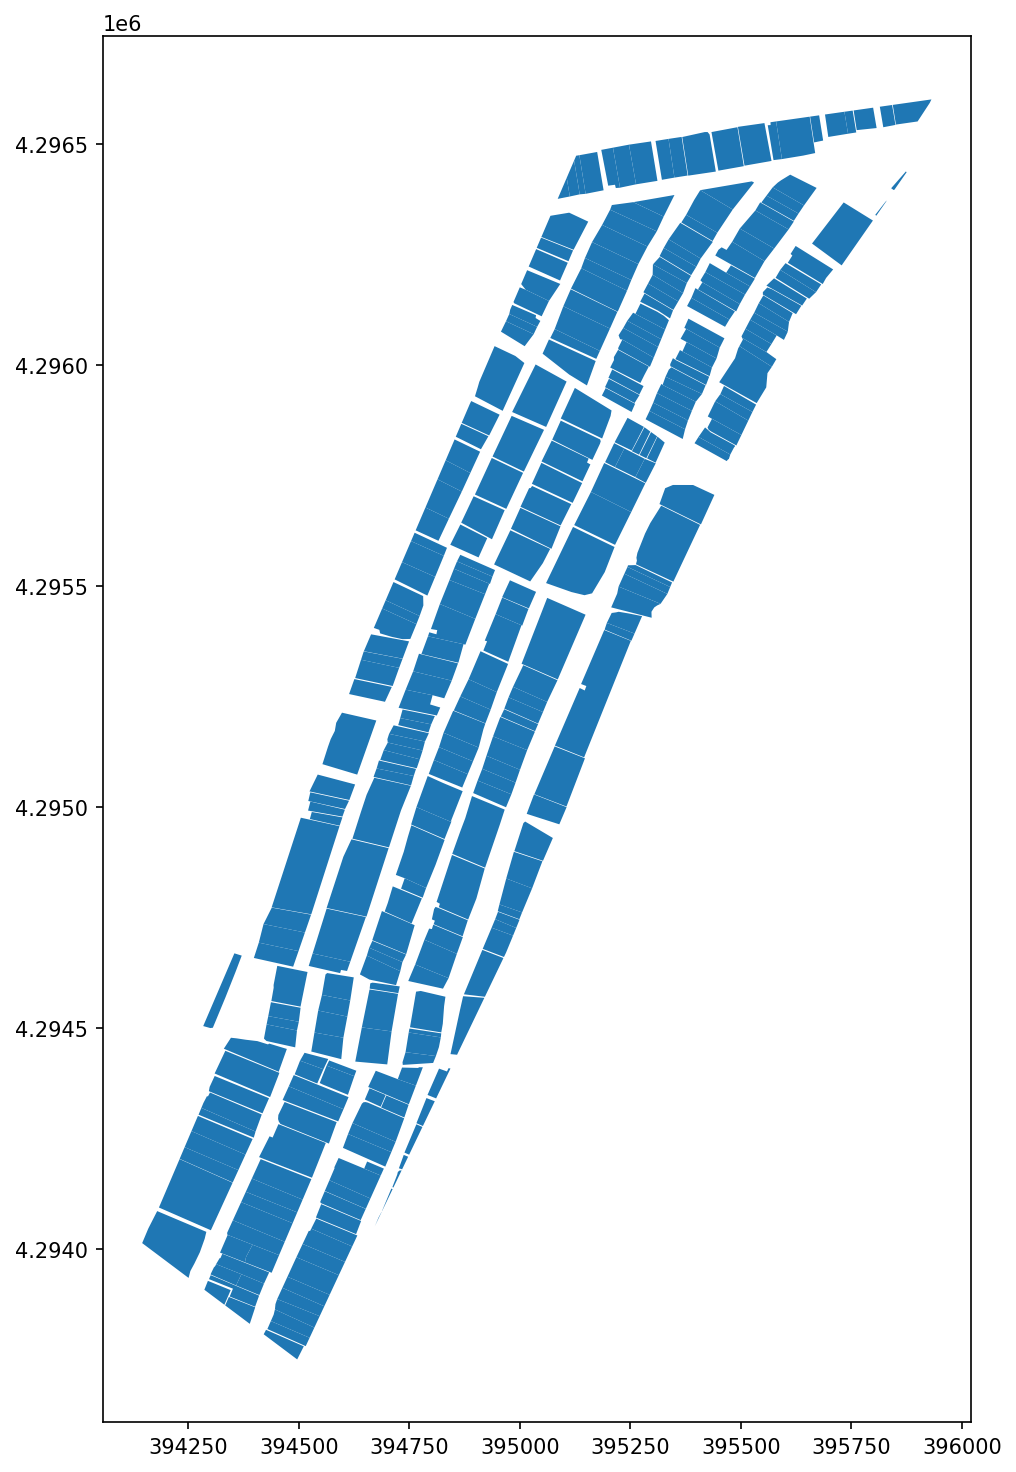

In [71]:
mergedGdf.plot(figsize=(12,12))

先程の全域のポリゴンから、その一部を切り抜くことができました。

改めて、foliumで確認してみましょう。

In [72]:
latlon = [38.7918,139.8118]
m = folium.Map(latlon,zoom_start=14, control_scale=True)
folium.GeoJson(mergedGdf).add_to(m)
m

作成したgeojsonの内部の畑のポリゴンのみが抽出されていることが確認できたかと思います。

In [73]:
mergedGdf.head()

area_ha_1                  id  area_ha_2  公開年度  調製年度 耕地の種類  \
0  172.35443  0610-131392-089672   0.439416  2021  2020     畑   
1  172.35443  0610-131405-089725   0.159186  2021  2020     畑   
2  172.35443  0610-131413-089776   0.245025  2021  2020     畑   
3  172.35443  0610-131420-089809   0.111604  2021  2020     畑   
4  172.35443  0610-131426-089840   0.260036  2021  2020     畑   

                                            geometry  areaIntersect  
0  POLYGON ((395930.983 4296600.484, 395927.225 4...       0.312972  
1  POLYGON ((395841.998 4296587.869, 395849.631 4...       0.129829  
2  POLYGON ((395799.147 4296581.795, 395807.032 4...       0.205761  
3  POLYGON ((395752.873 4296575.235, 395760.988 4...       0.094558  
4  POLYGON ((395734.165 4296572.583, 395742.467 4...       0.227904

畑のポリゴンの面積を計算しましょう。

In [74]:
mergedGdf.areaIntersect.sum() # 合計は約108ha

108.54663586794892

結合したファイルをshpとして保存します。これは次の作業で利用します。

In [111]:
mergedGdf.drop(columns={'area_ha_1','耕地の種類','area_ha_2'},inplace=True) # 余計な列の削除
# Convert 6691 to 4326 for using geemap
mergedGdf.to_crs('epsg:4326',inplace=True)
mergedGdf.to_file("/content/drive/MyDrive/Colab Notebooks/書籍notebooks/data/mergedShounai_4326.geojson", crs="epsg:4326") # GeoPandasをgeojsonとして保存

KeyError: "['耕地の種類', 'area_ha_1', 'area_ha_2'] not found in axis"

### 衛星データの取得

最後です。上で作ったポリゴンデータを用いて、任意の範囲のみの衛星データを描画します。

今回はGoogle Earth Engineから衛星データを取得します。

取得するデータは[MODIS/Terra Vegetation Index(MOD13Q1) Version 6](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13Q1)です。

- 16日周期で得られるデータです
- 地上分解能は250mとなります

MODISのデータは解像度は荒いですが、非常に大きな範囲を捉えています（日本であれば、h28-h29/v04-v05の3枚から4枚のタイルで覆えるくらいの大きさです)。そのため、興味のある場所で画像を切り取るのは大事な作業になります。

![modisTile](https://modis-land.gsfc.nasa.gov/images/MODIS_sinusoidal_grid1.gif)

<center>Source: National Aeronautics and Space Administration
Goddard Space Flight Center </center>

＊GEEを使う前に認証を行う必要があります。認証はGEEに登録済みのユーザーアカウントで行ってください。

参照：https://developers.google.com/earth-engine/guides/auth

In [78]:
import ee
ee.Authenticate()
ee.Initialize(project='ee-tamakisoranome')

In [116]:
Map = geemap.Map(center=latlon, zoom=14, control_scale=True)
# ee.FeatureCollectionへの変換
fudePoly = geemap.geojson_to_ee('/content/drive/MyDrive/Colab Notebooks/書籍notebooks/data/mergedShounai_4326.geojson')
# fudePolySimple = fudePoly.map(lambda feature: feature.simplify(maxError = 50))
Map.addLayer(fudePoly, {}, 'Shounai Hatake') # レイヤー名はShounai Hatake
Map

# 描画だけであれば、add_geojsonを利用することも可能
# Map = geemap.Map(center=latlon, zoom=14, control_scale=True)
# fudePoly = ('/content/drive/MyDrive/Colab Notebooks/書籍notebooks/data/mergedShounai_4326.geojson')
# Map.add_geojson(fudePoly, layer_name='Shounai Hatake',info_mode='on_hover') # レイヤー名はShounai Hatake
# Map

Map(center=[38.7918, 139.8118], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchD…

MOD13Q1からデータを取得します。Earth Engineでは、ラスターはImageCollection、ベクターはFeatureCollectionというコンストラクタ（メソッド）を用いて取得します。その名前の通り、取得するデータは全て大きなデータのまとまりになっています。

つまり、`ee.ImageCollection(...)`のようにすると、指定したデータでEarth Engineが持っている全てのデータ（アセット）を読み込むことになります。そのため、その後にデータを絞る必要があります。そこで用いられるのが、filterDateやfilterBoundsなどです。

In [95]:
# MODISデータの読み込み
# 今回は4月から9月までの範囲でデータを取得しています。
# EPSG:4326 (Default)
modis = ee.ImageCollection('MODIS/006/MOD13Q1') # IDの指定。今回はMODIS/006/MOD13Q1
modis = modis.filterDate(ee.DateRange('2019-04-01','2019-7-01')) # 2019年4月1日から2019年7月1日を取得

MOD13Q1に含まれるバンド情報を確認します。

In [96]:
modis.first().bandNames().getInfo()

['NDVI',
 'EVI',
 'DetailedQA',
 'sur_refl_b01',
 'sur_refl_b02',
 'sur_refl_b03',
 'sur_refl_b07',
 'ViewZenith',
 'SolarZenith',
 'RelativeAzimuth',
 'DayOfYear',
 'SummaryQA']

In [97]:
# 今回はNDVIのみ取得
# evi = modis.select('EVI')
ndvi = modis.select('NDVI')

NDVIのみを抽出しましょう。スケーリングが必要なため関数を定義し、値を調整します。

詳しくは[公式のドキュメント](https://lpdaac.usgs.gov/products/mod13q1v006/)、Layersを開いてください。Scale Factorと書かれているところが利用する値となります。

＊衛星データはそのままの値でなく、大きさを調整する必要があるときがあります。どのくらい調整すれば良いのかを示したものがScale Factorとなります。調整する必要がない場合には、Scale Factor = 1.0となっています。

In [98]:
# スケーリングのための関数
def scale_factor(image):
    return image.multiply(0.0001).copyProperties(image, ['system:time_start'])

# 取得した各々のデータに対して上の関数を実行(Mapping)
# scaled_evi = evi.map(scale_factor)
scaled_ndvi = ndvi.map(scale_factor)

In [117]:
gmap = geemap.Map(center=latlon, zoom=14, control_scale=True)
gmap.addLayer(scaled_ndvi.mean().clip(fudePoly), name='Averaged NDVI',# ４月から９月までの平均値を描画。clipでfudePoly内のピクセルだけ取得
              vis_params={'min': 0,
                         'max': 1,
                         'palette': ['red', 'yellow','green']})
gmap.addLayerControl()
gmap

Map(center=[38.7918, 139.8118], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchD…

関心領域（この場合はfudePoly）からNDVIの平均値を取得し、その日付と平均値を取得するための関数を作成します。

In [100]:
# 関心領域のピクセルから平均値を導出
def aoi_mean(img):
  # scaleには通常、そのラスターの解像度を渡します
  # mean = img.reduceRegion(reducer=ee.Reducer.mean().unweighted(), geometry=fudePoly, scale=250).get('NDVI') # 重みなし
  # mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=fudePoly).get('NDVI') # 重みなし
  mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=fudePoly, scale=250).get('NDVI') # 重みあり
  return img.set('date', img.date().format('Y-M-d')).set('mean',mean)

reduceRegionでは、対象とする地域を絞りつつ、[reducerによる重み付け平均](https://developers.google.com/earth-engine/apidocs/ee-reducer-mean)を行っています。[ee.Reducer](https://developers.google.com/earth-engine/guides/reducers_intro)には他にも様々な種類があります。

![reduce](https://developers.google.com/earth-engine/images/Reduce_region_diagram.png)

Source: https://developers.google.com/earth-engine/guides/reducers_reduce_region

上記で得られたee.Image（各々の画像データ）に対して、メタデータを付与しています。この場合は、日付と計算した平均値です。

先ほども登場したmapですが、Earth Engineでは基本的にfor文を使うことはありません。ImageCollectionは画像データの集まりなので、気持ちとしてはこれらのデータそれぞれにfor文で上の処理を行いたいところです。しかし、Earth Engineではfor文は推奨されていません。その理由として、高度な並列処理ができなくなるからだそうです。


詳しくは、[公式の情報](https://developers.google.com/earth-engine/tutorials/tutorial_js_03)をご覧ください。

In [118]:
ndvi_reduced_imgs = scaled_ndvi.map(aoi_mean)

In [119]:
nested_list = ndvi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','mean']).values().get(0)

平均値を求めたImageCollectionから、指定した列のみを抽出したい場合、reduceColumnsを利用します。[reduceColumns](https://developers.google.com/earth-engine/apidocs/ee-imagecollection-reducecolumns)では出力は辞書型になりますので、[ee.Reducer.toList](https://developers.google.com/earth-engine/apidocs/ee-reducer-tolist)をを用いて出力をリスト型に変えています。最後に値のみを抽出し、リストの内側のみの値を取り出します。

これでデータフレームを作成する準備ができました。

In [120]:
df = pd.DataFrame(nested_list.getInfo(), columns=['date','ndvi'])
df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')

In [121]:
df

date      ndvi
0 2019-04-07  0.345013
1 2019-04-23  0.367106
2 2019-05-09  0.436482
3 2019-05-25  0.459187
4 2019-06-10  0.336669
5 2019-06-26  0.501830

描画を行います。

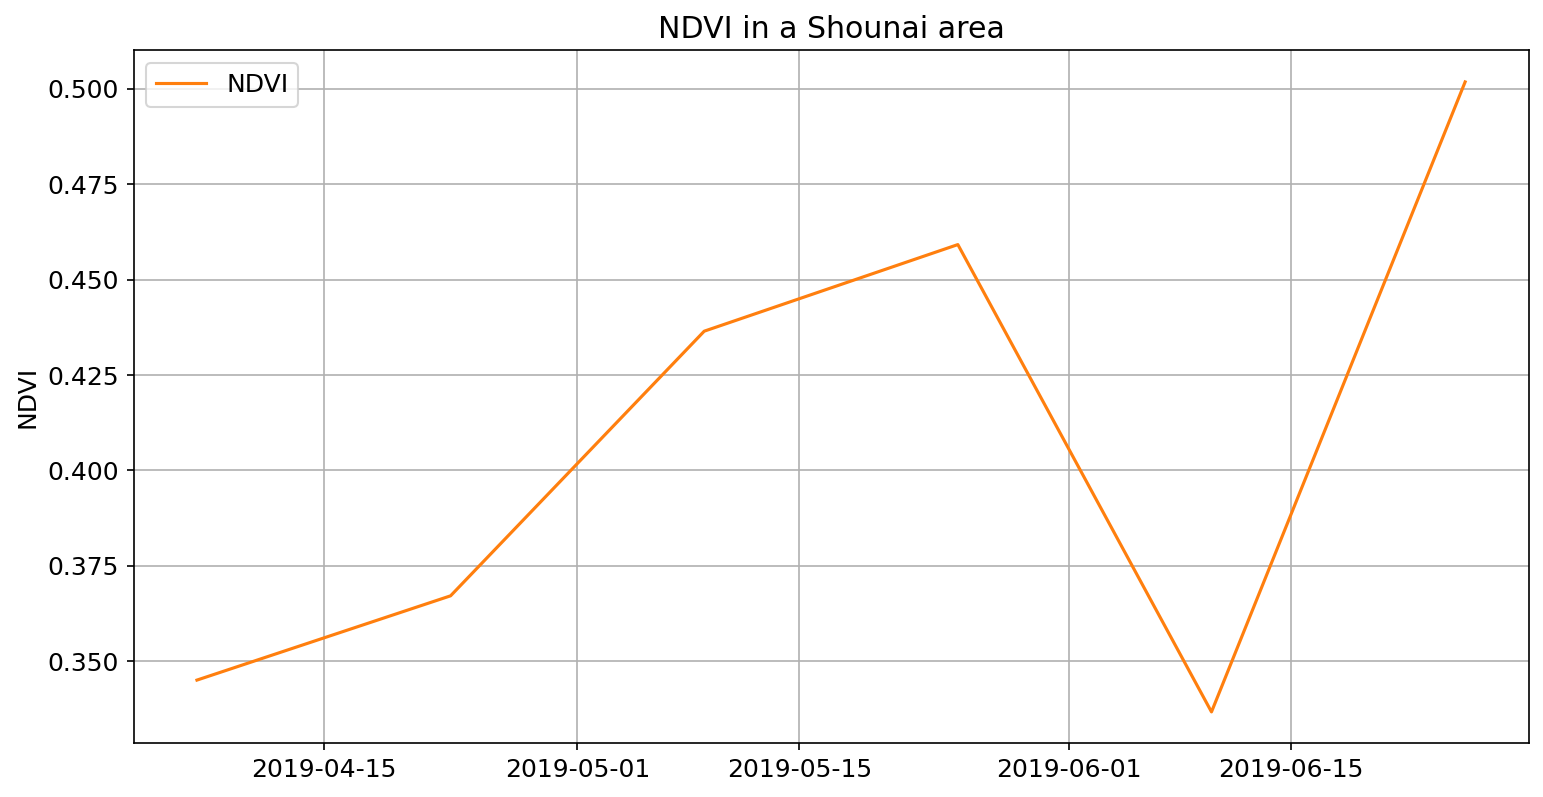

In [122]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(12, 6))

# 線の見た目調整
ax.plot(df.date, df.ndvi, color='tab:orange', label='NDVI')

# ラベルとタイトルなど
ax.set_xlabel('')
ax.set_ylabel('NDVI')
ax.set_title('NDVI in a Shounai area')
ax.grid(True)
ax.legend(loc='upper left'); # レジェンドの位置

やや面倒ですが、このような作業で自分の興味範囲のみの衛星画像データをデータフレームにすることができます。今回は筆ポリゴンの面積も求めていますので、収量予測のモデルが作れれば、面積あたりの収量を予測することも可能です。